# Flight Delay Analysis

### Importing Libraries, these libraries are used overall for our analysis. Spark is intalled and we setup the envoirment in command prompt and the using libraries we import the spark session

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import warnings

warnings.filterwarnings('ignore')


In [2]:
dataset_file = 'Flight_delay.csv'

# Read input data from the dataset file
data = pd.read_csv(dataset_file)
print(data)

        DayOfWeek        Date  DepTime  ArrTime  CRSArrTime UniqueCarrier  \
0               4  03-01-2019     1829     1959        1925            WN   
1               4  03-01-2019     1937     2037        1940            WN   
2               4  03-01-2019     1644     1845        1725            WN   
3               4  03-01-2019     1452     1640        1625            WN   
4               4  03-01-2019     1323     1526        1510            WN   
...           ...         ...      ...      ...         ...           ...   
484546          5  13-06-2019     1609     1942        1915            AA   
484547          6  14-06-2019     1616     1954        1915            AA   
484548          2  17-06-2019     1617     2002        1915            AA   
484549          7  22-06-2019     1607     1941        1915            AA   
484550          1  23-06-2019     1608     1933        1915            AA   

                       Airline  FlightNum TailNum  ActualElapsedTime  ...  

In [3]:
# Define column names based on our data
columns = ['DayOfWeek', 'Date', 'DepTime', 'ArrTime', 'CRSArrTime', 
            'UniqueCarrier', 'Airline', 'FlightNum', 'TailNum', 
            'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 
            'ArrDelay', 'DepDelay', 'Origin', 'Org_Airport', 
            'Dest', 'Dest_Airport', 'Distance', 'TaxiIn', 
            'TaxiOut', 'Cancelled', 'CancellationCode', 'Diverted', 
            'CarrierDelay', 'WeatherDelay', 'NASDelay', 
            'SecurityDelay', 'LateAircraftDelay']

In [193]:
# Assign column names if they are not present in the CSV file
if data.columns.size != len(columns):
    data.columns = columns

In [4]:
# Descriptive statistics for numerical columns
print(data.describe())

# Summarize categorical columns
print(data.describe(include=['object']))

           DayOfWeek        DepTime        ArrTime     CRSArrTime  \
count  484551.000000  484551.000000  484551.000000  484551.000000   
mean        3.991605    1564.477865    1617.784438    1652.129929   
std         1.971466     452.235219     583.637660     466.096216   
min         1.000000       1.000000       1.000000       1.000000   
25%         2.000000    1234.000000    1327.000000    1339.000000   
50%         4.000000    1620.000000    1737.000000    1723.000000   
75%         6.000000    1928.000000    2049.000000    2025.000000   
max         7.000000    2400.000000    2400.000000    2359.000000   

           FlightNum  ActualElapsedTime  CRSElapsedTime        AirTime  \
count  484551.000000      484551.000000   484551.000000  484551.000000   
mean     2139.207386         134.810422      131.400761     108.877134   
std      1812.677071          74.070374       71.542531      70.113513   
min         1.000000          15.000000      -21.000000       0.000000   
25%     

# Data Preprocessing

In [5]:
# Convert columns to appropriate data types
data['ArrDelay'] = pd.to_numeric(data['ArrDelay'], errors='coerce')
data['DepDelay'] = pd.to_numeric(data['DepDelay'], errors='coerce')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')
data['DayOfWeek'] = data['Date'].dt.weekday + 1
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['DepTime'] = pd.to_numeric(data['DepTime'], errors='coerce')
data['ArrTime'] = pd.to_numeric(data['ArrTime'], errors='coerce')
data['AirTime'] = pd.to_numeric(data['AirTime'], errors='coerce')
data['Distance'] = pd.to_numeric(data['Distance'], errors='coerce')
data['CarrierDelay'] = pd.to_numeric(data['CarrierDelay'], errors='coerce')
data['WeatherDelay'] = pd.to_numeric(data['WeatherDelay'], errors='coerce')
data['NASDelay'] = pd.to_numeric(data['NASDelay'], errors='coerce')
data['SecurityDelay'] = pd.to_numeric(data['SecurityDelay'], errors='coerce')
data['LateAircraftDelay'] = pd.to_numeric(data['LateAircraftDelay'], errors='coerce')

# Convert to Pandas DataFrame for EDA
pdf = data.copy()

In [6]:
null_values = data.isnull().sum()
print(null_values)

DayOfWeek               0
Date                    0
DepTime                 0
ArrTime                 0
CRSArrTime              0
UniqueCarrier           0
Airline                 0
FlightNum               0
TailNum                 0
ActualElapsedTime       0
CRSElapsedTime          0
AirTime                 0
ArrDelay                0
DepDelay                0
Origin                  0
Org_Airport          1177
Dest                    0
Dest_Airport         1479
Distance                0
TaxiIn                  0
TaxiOut                 0
Cancelled               0
CancellationCode        0
Diverted                0
CarrierDelay            0
WeatherDelay            0
NASDelay                0
SecurityDelay           0
LateAircraftDelay       0
Year                    0
Month                   0
dtype: int64


The dataset contains 484,551 rows. Dropping rows 1177 and 1479 is justified because they represent less than 5% of the total dataset. Therefore, removing them will not significantly impact the analysis.

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

#  'pdf' is our DataFrame 

# Analyze Missing Values
missing_percentage = pdf.isnull().sum() * 100 / len(pdf)
print(missing_percentage)





DayOfWeek            0.000000
Date                 0.000000
DepTime              0.000000
ArrTime              0.000000
CRSArrTime           0.000000
UniqueCarrier        0.000000
Airline              0.000000
FlightNum            0.000000
TailNum              0.000000
ActualElapsedTime    0.000000
CRSElapsedTime       0.000000
AirTime              0.000000
ArrDelay             0.000000
DepDelay             0.000000
Origin               0.000000
Org_Airport          0.242905
Dest                 0.000000
Dest_Airport         0.305231
Distance             0.000000
TaxiIn               0.000000
TaxiOut              0.000000
Cancelled            0.000000
CancellationCode     0.000000
Diverted             0.000000
CarrierDelay         0.000000
WeatherDelay         0.000000
NASDelay             0.000000
SecurityDelay        0.000000
LateAircraftDelay    0.000000
Year                 0.000000
Month                0.000000
dtype: float64


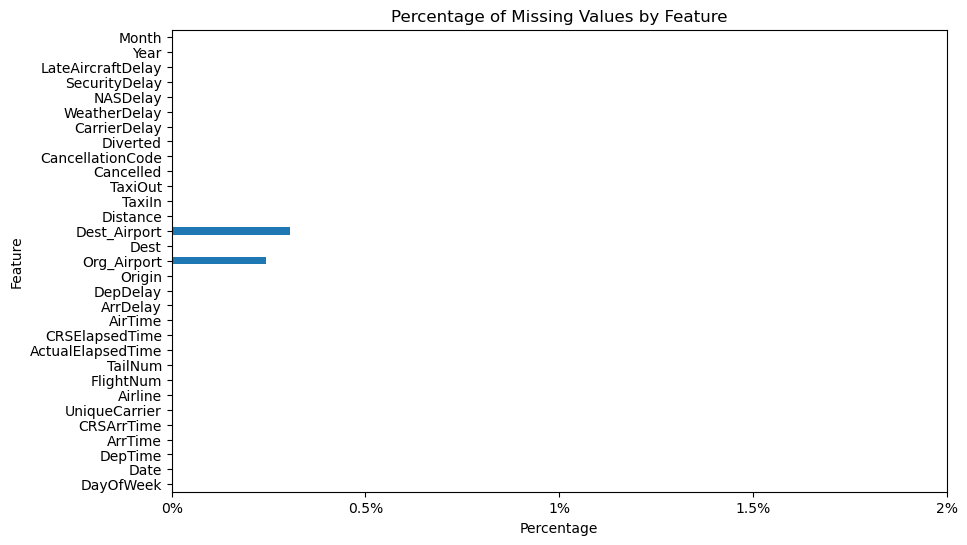

In [8]:
# Plot missing values
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='barh')
plt.title('Percentage of Missing Values by Feature')
plt.xlabel('Percentage')
plt.ylabel('Feature')

plt.xticks([0, 0.5, 1, 1.5, 2], ['0%', '0.5%', '1%', '1.5%', '2%'])

plt.show()




In [199]:
# Drop rows with missing values
pdf_cleaned = pdf.dropna()

# Verify if any missing values remain
print(pdf_cleaned.isnull().sum())

DayOfWeek            0
Date                 0
DepTime              0
ArrTime              0
CRSArrTime           0
UniqueCarrier        0
Airline              0
FlightNum            0
TailNum              0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Org_Airport          0
Dest                 0
Dest_Airport         0
Distance             0
TaxiIn               0
TaxiOut              0
Cancelled            0
CancellationCode     0
Diverted             0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
Year                 0
Month                0
dtype: int64


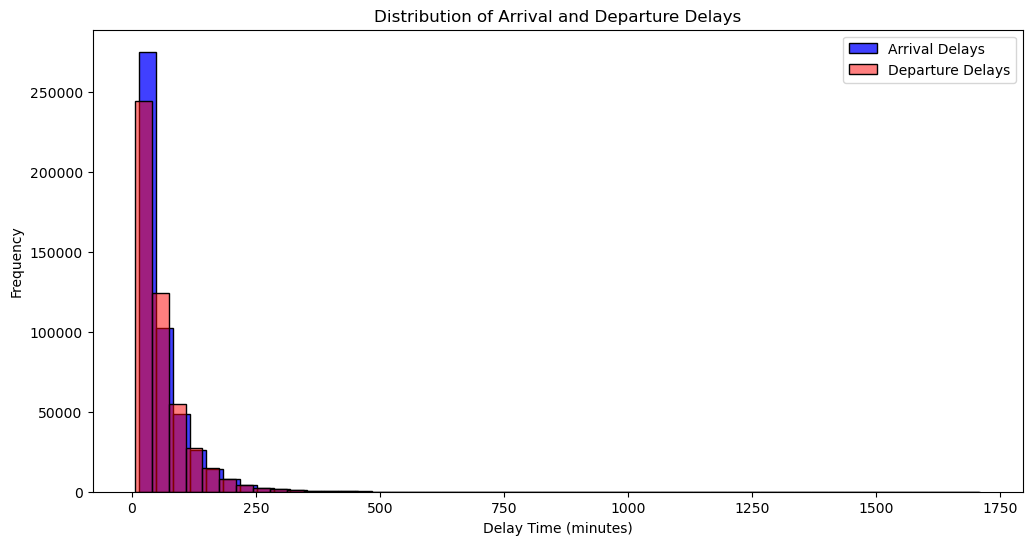

In [9]:
# Assign numeric identifiers to airlines
airline_codes = {name: f"Airline {i+1}" for i, name in enumerate(data['Airline'].unique())}
data['AirlineCode'] = data['Airline'].map(airline_codes)

# Plot distribution of arrival and departure delays
plt.figure(figsize=(12, 6))
sns.histplot(data['ArrDelay'], bins=50, color='blue', label='Arrival Delays')
sns.histplot(data['DepDelay'], bins=50, color='red', alpha=0.5, label='Departure Delays')
plt.xlabel('Delay Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Arrival and Departure Delays')
plt.legend()


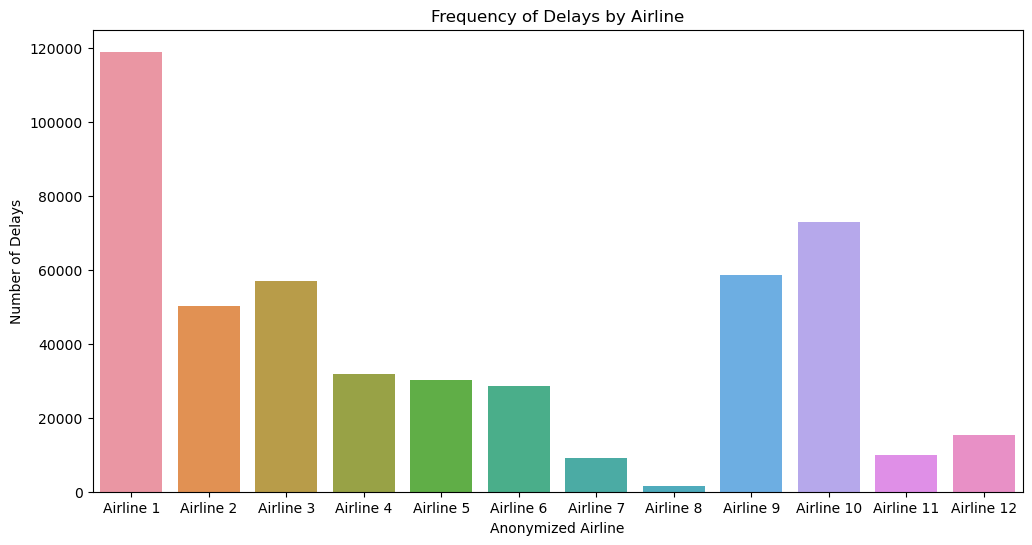

In [10]:
# Frequency of delays by anonymized airlines
plt.figure(figsize=(12, 6))
sns.countplot(x='AirlineCode', data=data)
plt.title('Frequency of Delays by Airline')
plt.xlabel('Anonymized Airline')
plt.ylabel('Number of Delays')
plt.show()


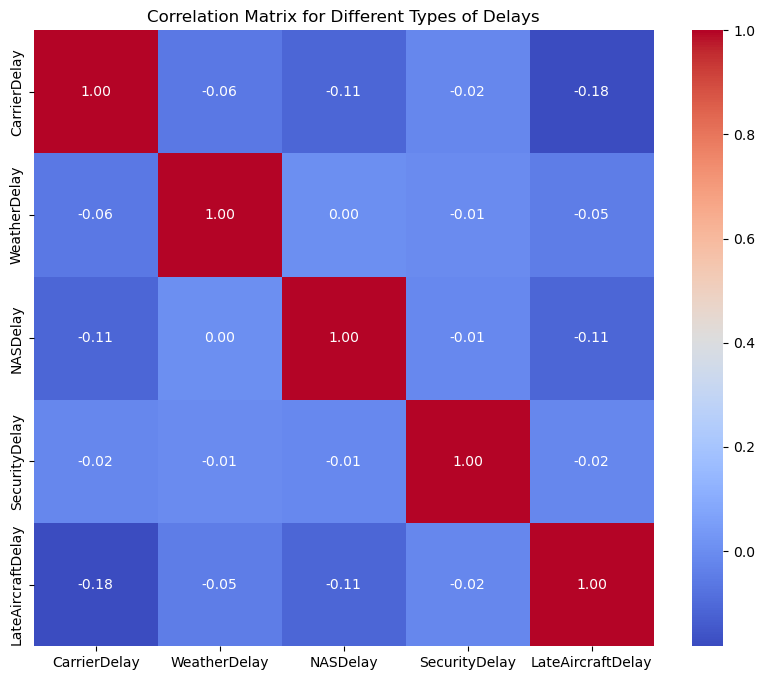

In [11]:
# Correlation Analysis of Different Delays
delay_types = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
correlation_matrix = data[delay_types].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Different Types of Delays')
plt.show()



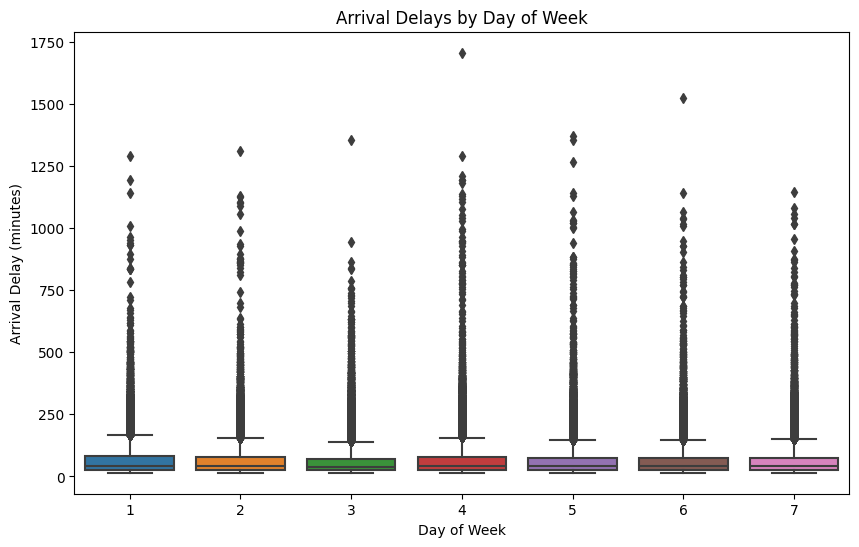

In [203]:
# 1. Day of Week Analysis
plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='ArrDelay', data=data)
plt.title('Arrival Delays by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Arrival Delay (minutes)')
plt.show()





DayOfWeek
1    13.950498
2    13.808648
3    13.769313
4    18.182601
5    13.804392
6    12.439522
7    14.045026
Name: ArrDelay, dtype: float64


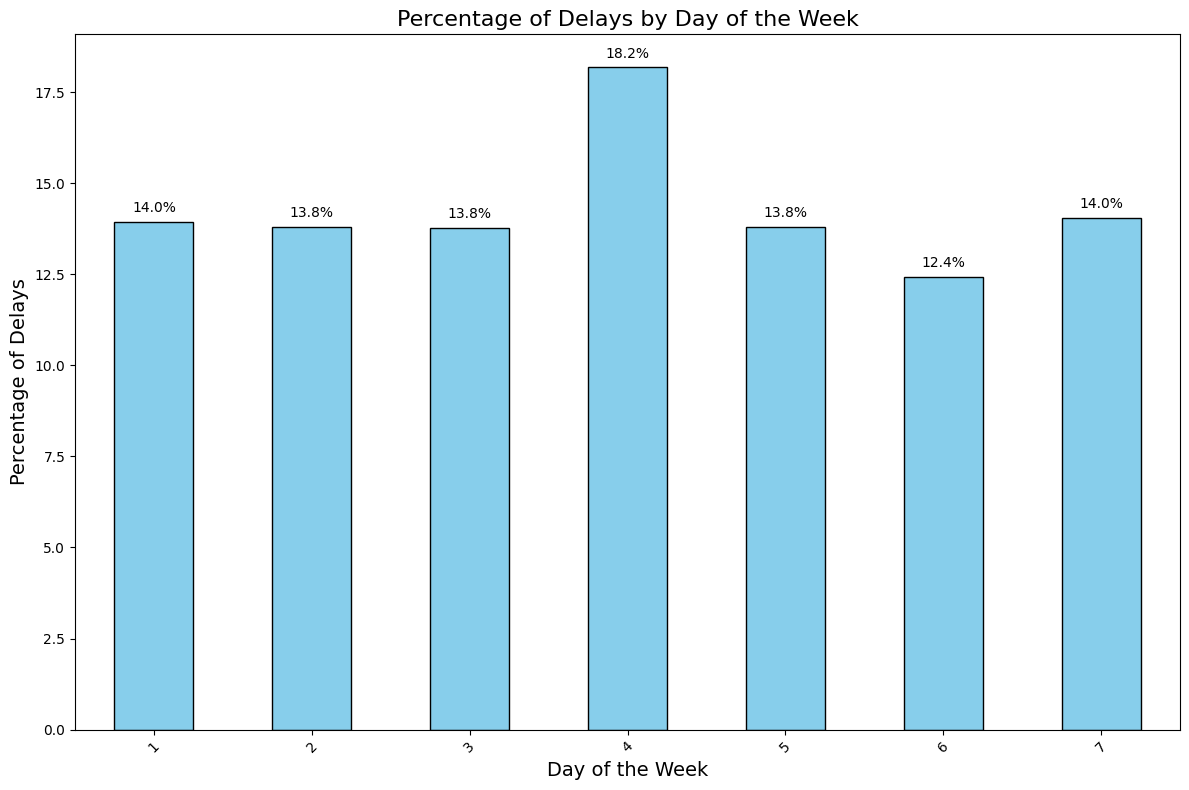

In [221]:
import matplotlib.pyplot as plt

# Group and Sum Delays by Day of the Week
delays_by_day = pdf.groupby('DayOfWeek')['ArrDelay'].sum()

# Calculate Total Delays
total_delays = pdf['ArrDelay'].sum()

# Compute Percentage of Delays by Day of the Week
delays_by_day_percentage = (delays_by_day / total_delays) * 100

# Print the Percentage of Delays
print(delays_by_day_percentage)

# Plotting the Data
plt.figure(figsize=(12, 8))
ax = delays_by_day_percentage.plot(kind='bar', color='skyblue', edgecolor='black')

# Add Data Labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Percentage of Delays by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Percentage of Delays', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()


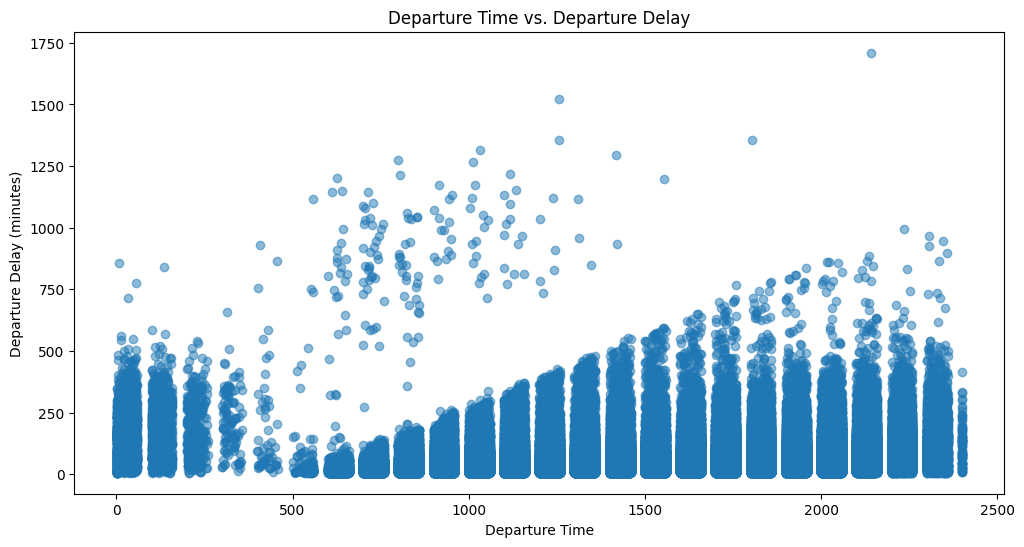

In [205]:
# 2. Flight Time Analysis
plt.figure(figsize=(12, 6))
plt.scatter(data['DepTime'], data['DepDelay'], alpha=0.5)
plt.title('Departure Time vs. Departure Delay')
plt.xlabel('Departure Time')
plt.ylabel('Departure Delay (minutes)')
plt.show()


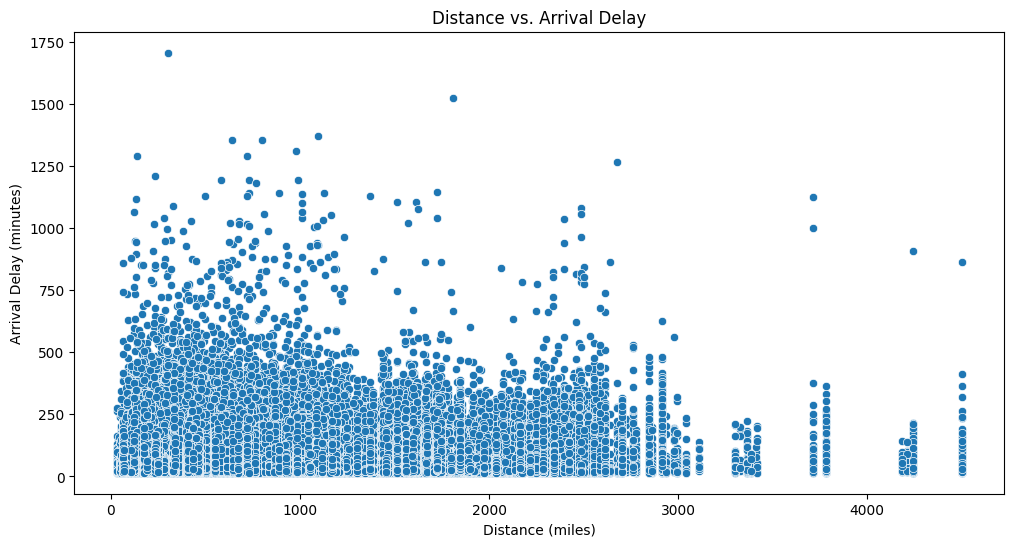

In [206]:
# 3. Distance Analysis
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Distance', y='ArrDelay', data=data)
plt.title('Distance vs. Arrival Delay')
plt.xlabel('Distance (miles)')
plt.ylabel('Arrival Delay (minutes)')
plt.show()



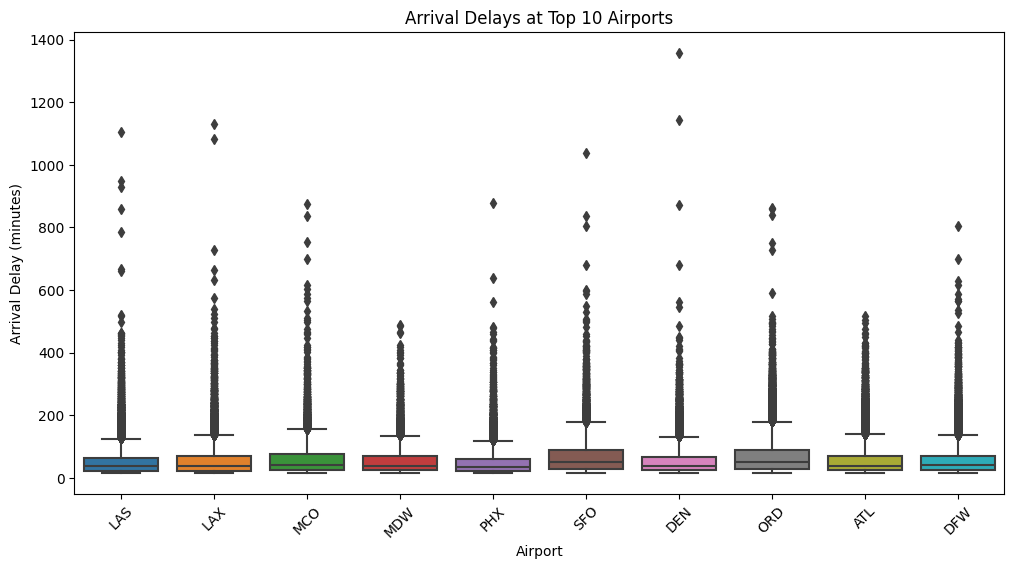

In [243]:
# 4. Airport Analysis (Top 10 airports by volume)
top_airports = data['Origin'].value_counts().nlargest(10).index
filtered_data = data[data['Origin'].isin(top_airports)]
plt.figure(figsize=(12, 6))
sns.boxplot(x='Origin', y='ArrDelay', data=filtered_data)
plt.xticks(rotation=45)
plt.title('Arrival Delays at Top 10 Airports')
plt.xlabel('Airport')
plt.ylabel('Arrival Delay (minutes)')
plt.show()


### Top 10 Routes with most Flight Delays

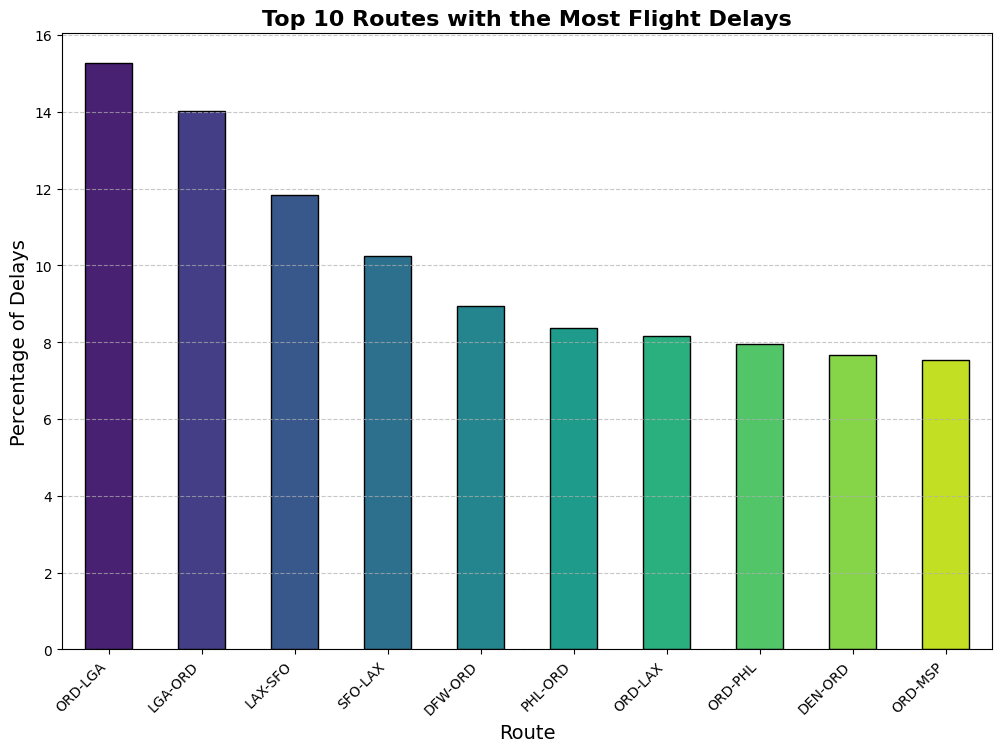

In [241]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your DataFrame
data['Route'] = data['Origin'] + '-' + data['Dest']
route_delays = data.groupby('Route')['ArrDelay'].sum()
top_routes = route_delays.nlargest(10)  # Top 10 routes with the most delays
percentage_top_routes = (top_routes / top_routes.sum()) * 100

# Plotting top route delays with enhanced visuals
plt.figure(figsize=(12, 8))
palette = sns.color_palette("viridis", len(top_routes))  # Using a viridis color palette
percentage_top_routes.plot(kind='bar', color=palette, edgecolor='black')

# Adding titles and labels
plt.title('Top 10 Routes with the Most Flight Delays', fontsize=16, weight='bold')
plt.xlabel('Route', fontsize=14)
plt.ylabel('Percentage of Delays', fontsize=14)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Displaying the plot
plt.show()


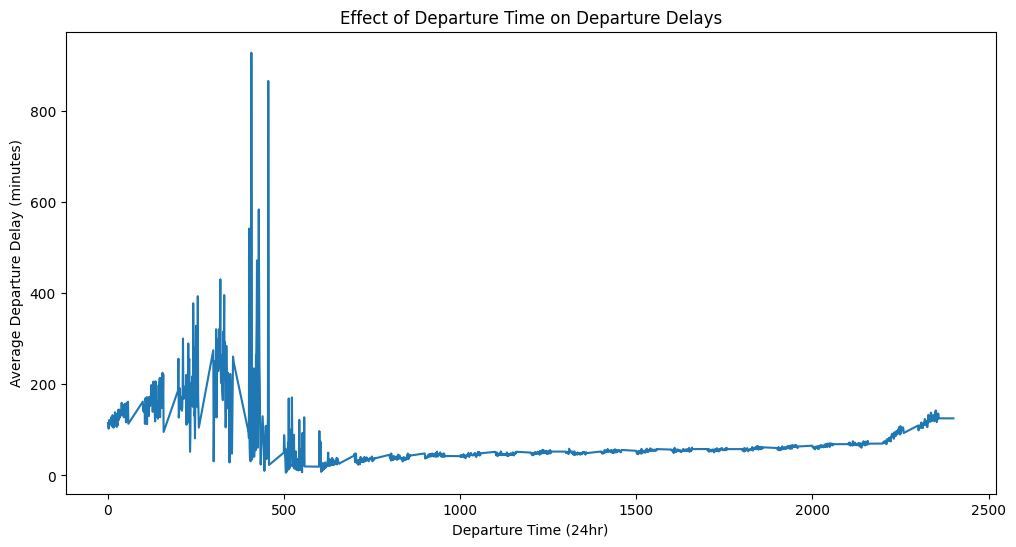

In [208]:
#5. Effect of Day Time on Delays
plt.figure(figsize=(12, 6))
sns.lineplot(x='DepTime', y='DepDelay', data=data, ci=None)
plt.title('Effect of Departure Time on Departure Delays')
plt.xlabel('Departure Time (24hr)')
plt.ylabel('Average Departure Delay (minutes)')
plt.show()



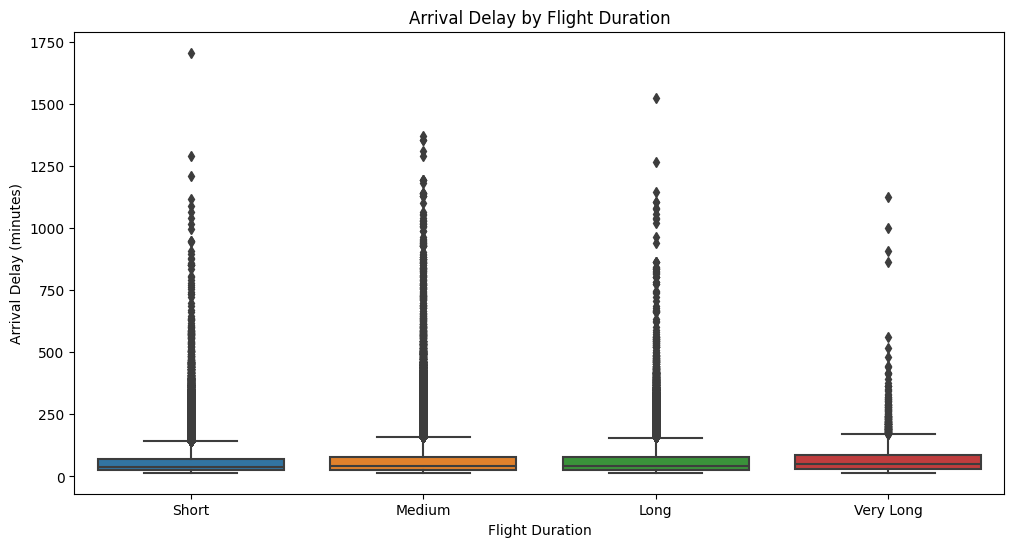

In [209]:
import matplotlib.colors as mcolors
#6. Delay Impact by Flight Duration
data['FlightDurationCategory'] = pd.cut(data['AirTime'], bins=[0, 60, 180, 360, 720], labels=['Short', 'Medium', 'Long', 'Very Long'])
plt.figure(figsize=(12, 6))
sns.boxplot(x='FlightDurationCategory', y='ArrDelay', data=data)
plt.title('Arrival Delay by Flight Duration')
plt.xlabel('Flight Duration')
plt.ylabel('Arrival Delay (minutes)')
plt.show()





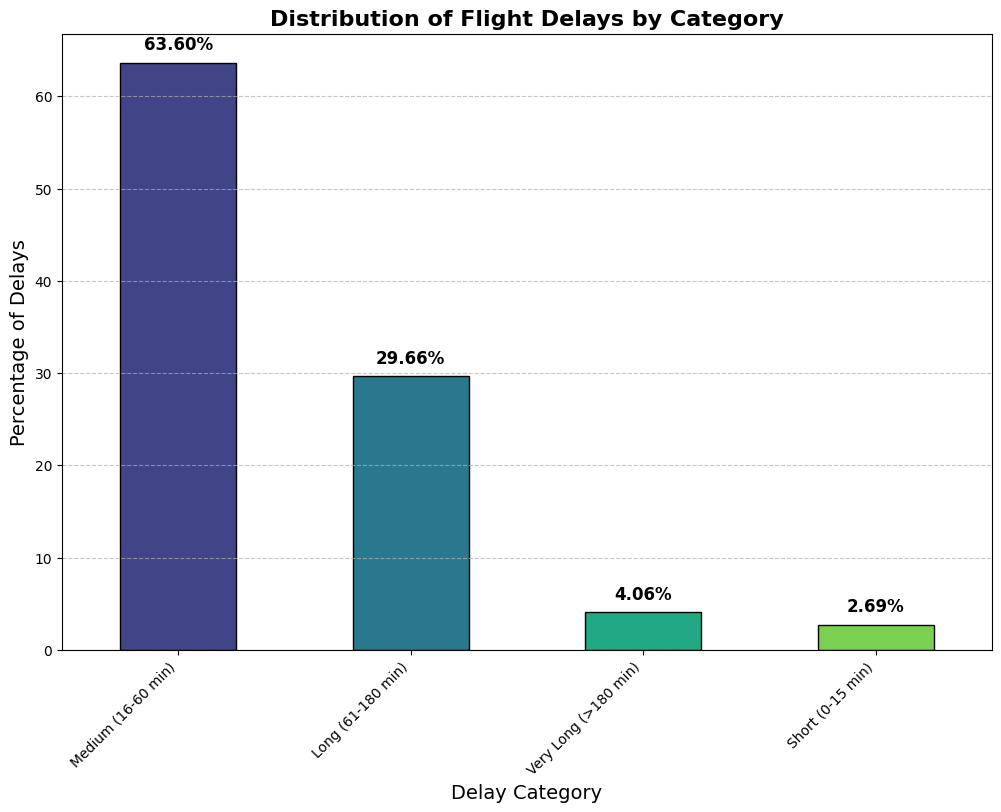

In [248]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data creation (assuming 'data' is your DataFrame)
# data = pd.DataFrame({
#     'ArrDelay': [10, -5, 20, 50, 300, 60, 0, 15, 45, 100, 200, -3, 90, 180, 250, 5, 25, 15, -2]
# })

# Define the bins and labels
bins = [-float('inf'), 15, 60, 180, float('inf')]  # Including -inf to 15 for short delays
labels = ['Short (0-15 min)', 'Medium (16-60 min)', 'Long (61-180 min)', 'Very Long (>180 min)']

# Categorize the delays
data['DelayCategory'] = pd.cut(data['ArrDelay'], bins=bins, labels=labels, right=True)

# Calculate the percentage of each delay category
delay_distribution = data['DelayCategory'].value_counts(normalize=True) * 100

# Plotting the distribution of delay categories
plt.figure(figsize=(12, 8))
colors = sns.color_palette("viridis", len(labels))  # Using a viridis color palette
ax = delay_distribution.plot(kind='bar', color=colors, edgecolor='black')

# Adding titles and labels
plt.title('Distribution of Flight Delays by Category', fontsize=16, weight='bold')
plt.xlabel('Delay Category', fontsize=14)
plt.ylabel('Percentage of Delays', fontsize=14)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding annotations for each bar to denote the percentages
for i in range(len(delay_distribution)):
    plt.text(i, delay_distribution[i] + 1, f"{delay_distribution[i]:.2f}%", ha='center', va='bottom', fontsize=12, weight='bold')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Displaying the plot
plt.show()


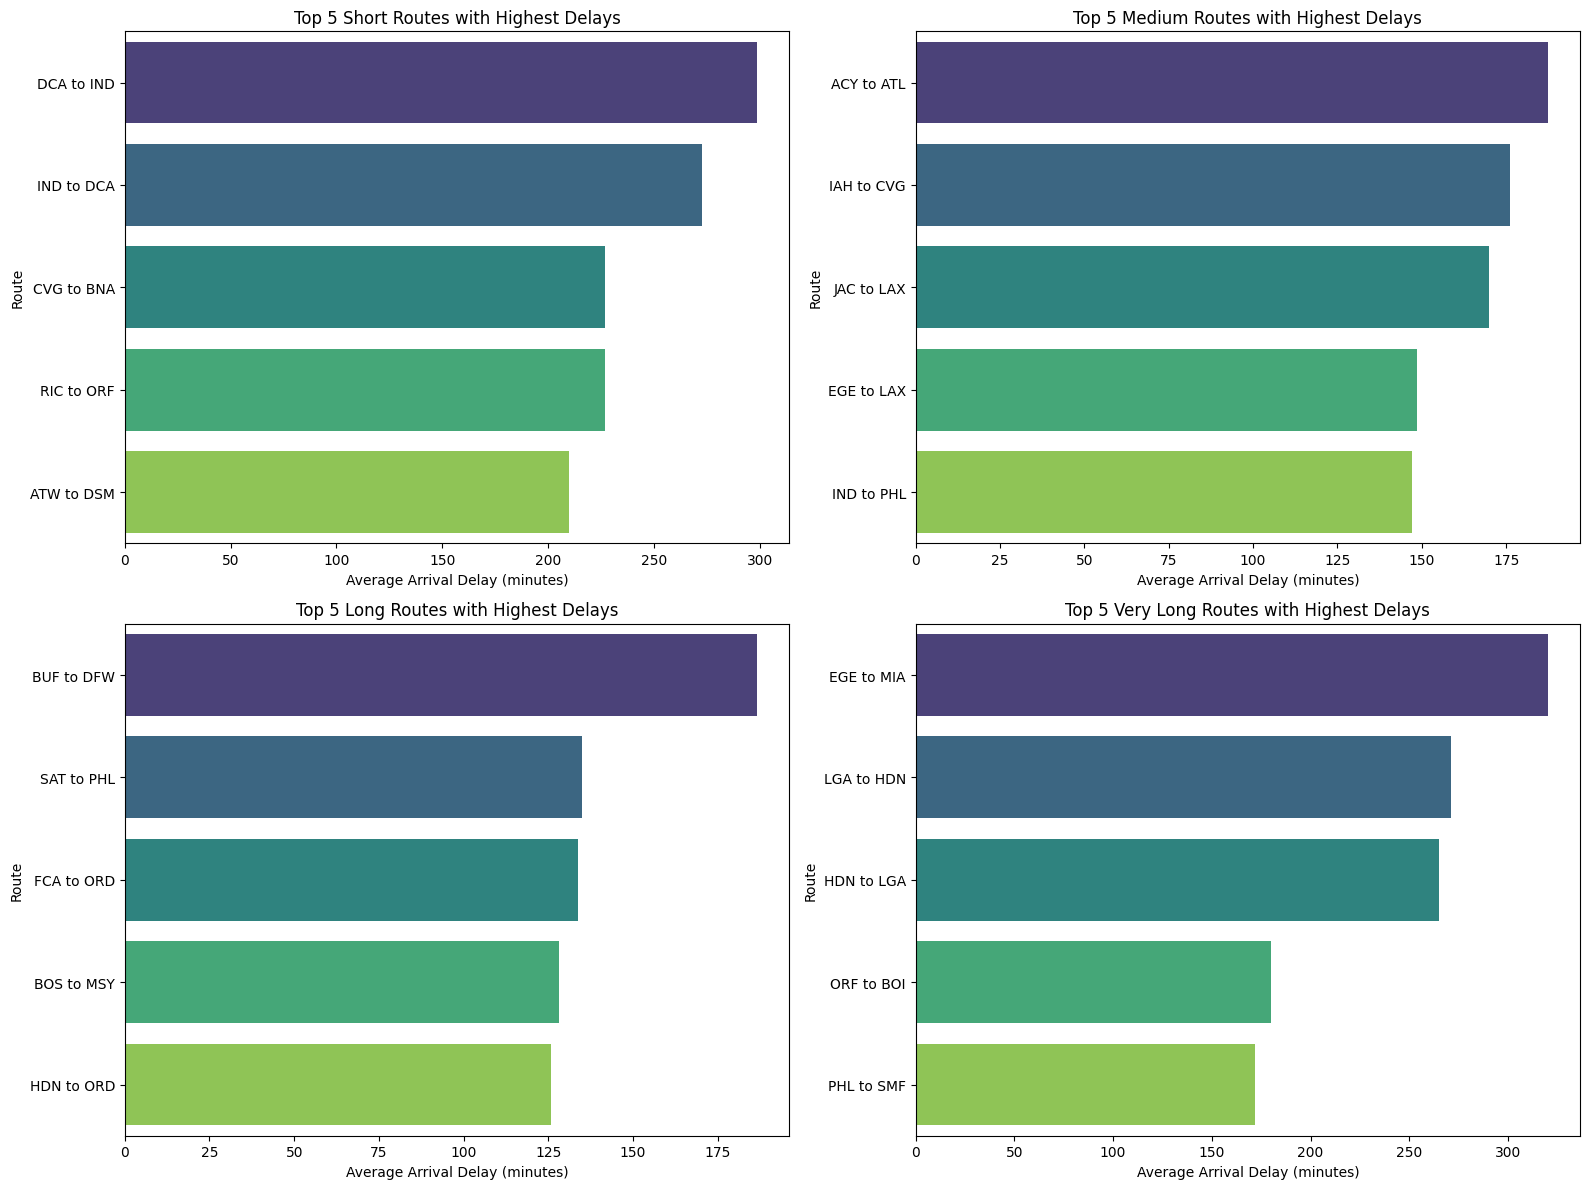

In [254]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data (assuming 'data' is your DataFrame)
# data = pd.read_csv('path_to_your_data.csv')


# Assuming the data has been loaded into a DataFrame called 'data'
# Define distance bins for categorization
bins = [0, 500, 1000, 1500, float('inf')]
labels = ['Short', 'Medium', 'Long', 'Very Long']

# Categorize the distance
data['DistanceCategory'] = pd.cut(data['Distance'], bins=bins, labels=labels, right=False)

# Calculate average arrival delay by route (Origin and Destination)
route_delays = data.groupby(['Origin', 'Dest', 'DistanceCategory'])['ArrDelay'].mean().reset_index()
route_delays.rename(columns={'ArrDelay': 'AvgArrDelay'}, inplace=True)

# Extract top 5 routes for each distance category based on average arrival delay
top_routes = {}
for label in labels:
    routes_in_category = route_delays[route_delays['DistanceCategory'] == label]
    top_routes[label] = routes_in_category.nlargest(5, 'AvgArrDelay')

# Plotting
plt.figure(figsize=(16, 12))

# Create a plot for each distance category
for idx, label in enumerate(labels):
    plt.subplot(2, 2, idx + 1)
    top_routes_df = top_routes[label]
    top_routes_df['Route'] = top_routes_df.apply(lambda row: f"{row['Origin']} to {row['Dest']}", axis=1)
    sns.barplot(data=top_routes_df, x='AvgArrDelay', y='Route', palette='viridis')
    plt.title(f'Top 5 {label} Routes with Highest Delays')
    plt.xlabel('Average Arrival Delay (minutes)')
    plt.ylabel('Route')

# Adjust layout
plt.tight_layout()
plt.show()


Route with highest average delay: EGE-MIA with 320.44 minutes
Route with lowest average delay: LAX-JAX with 15.00 minutes


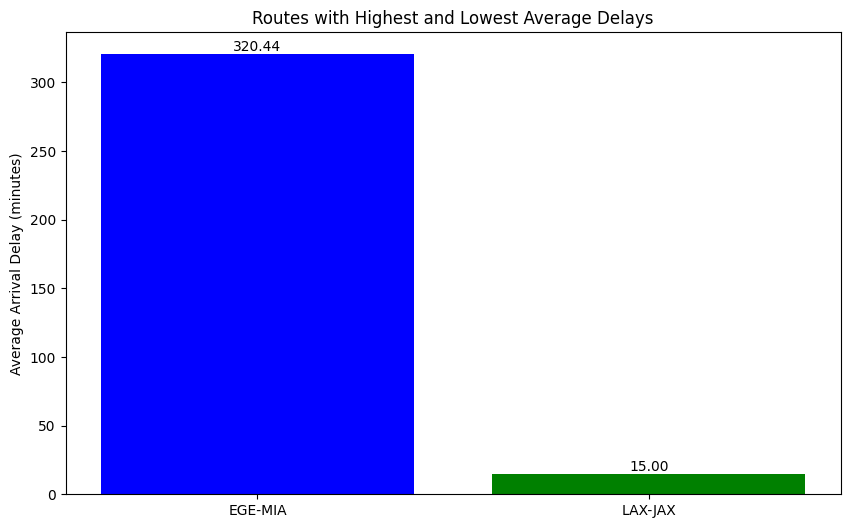

In [259]:
# Assuming 'pdf' is your DataFrame and has been properly loaded
# Add a new column 'Route' by combining 'Origin' and 'Dest'
pdf['Route'] = pdf['Origin'] + '-' + pdf['Dest']

# Calculate the average arrival delay by route
avg_delay_by_route = pdf.groupby('Route')['ArrDelay'].mean().sort_values()

# Identify the routes with the highest and lowest average delays
highest_avg_delay_route = avg_delay_by_route.idxmax()
lowest_avg_delay_route = avg_delay_by_route.idxmin()

highest_avg_delay = avg_delay_by_route.max()
lowest_avg_delay = avg_delay_by_route.min()

# Print the results
print(f"Route with highest average delay: {highest_avg_delay_route} with {highest_avg_delay:.2f} minutes")
print(f"Route with lowest average delay: {lowest_avg_delay_route} with {lowest_avg_delay:.2f} minutes")

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for highest and lowest average delays
# Note: Using ax.bar with multiple bars; use ax.barh for horizontal bars if needed
routes = [highest_avg_delay_route, lowest_avg_delay_route]
delays = [highest_avg_delay, lowest_avg_delay]
colors = ['blue', 'green']

# Adding bars
ax.bar(routes, delays, color=colors, tick_label=routes)

# Adding labels and title
ax.set_ylabel('Average Arrival Delay (minutes)')
ax.set_title('Routes with Highest and Lowest Average Delays')

# Adding value labels on bars for better readability
for i in range(len(routes)):
    ax.text(routes[i], delays[i], f'{delays[i]:.2f}', ha='center', va='bottom')

plt.show()


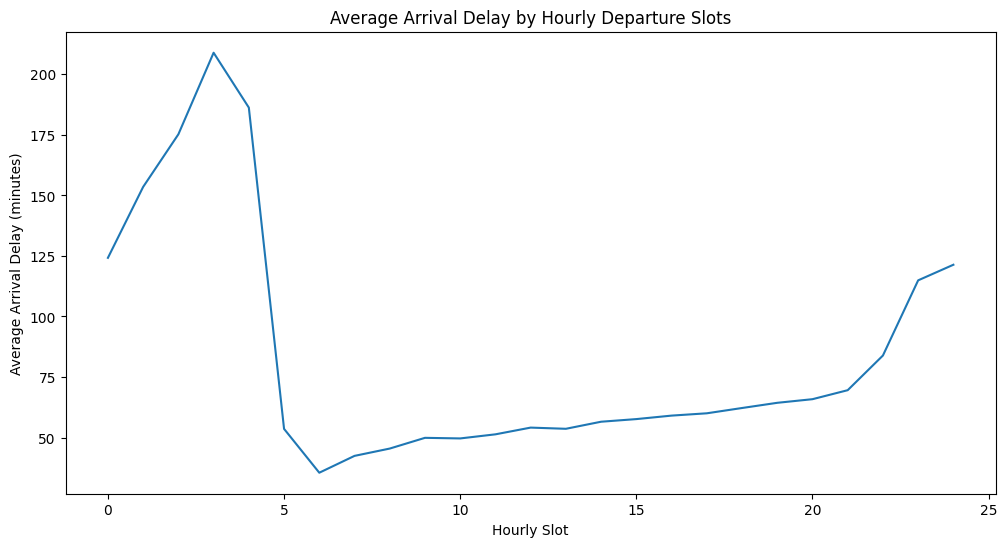

In [210]:

#7. Visualization of Delay Propagation
data['HourlySlot'] = data['DepTime'] // 100
pivot_delay_propagation = data.pivot_table(values='ArrDelay', index='HourlySlot', aggfunc='mean')
plt.figure(figsize=(12, 6))
sns.lineplot(x=pivot_delay_propagation.index, y=pivot_delay_propagation['ArrDelay'])
plt.title('Average Arrival Delay by Hourly Departure Slots')
plt.xlabel('Hourly Slot')
plt.ylabel('Average Arrival Delay (minutes)')
plt.show()

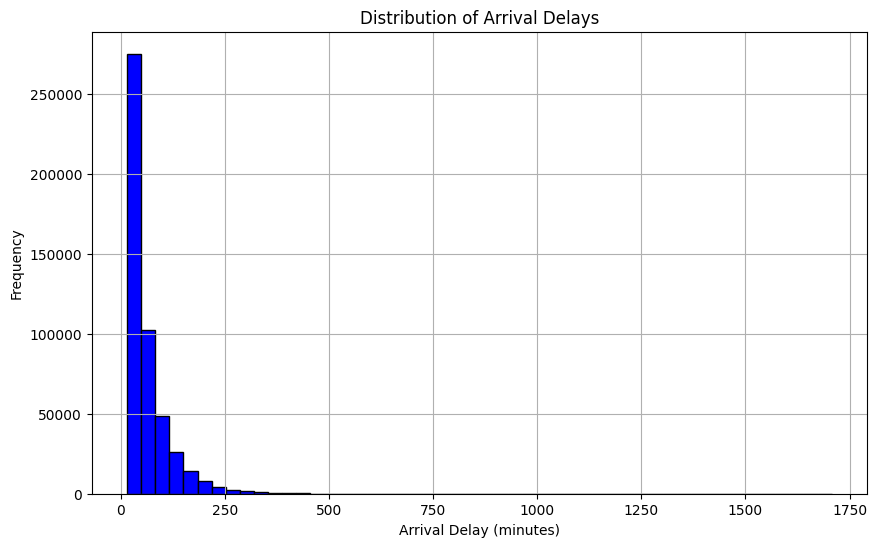

In [211]:
# Ensure 'ArrDelay' column is numerical and handle any missing values
data['ArrDelay'].dropna(inplace=True)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(data['ArrDelay'], bins=50, color='blue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Distribution of Arrival Delays')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


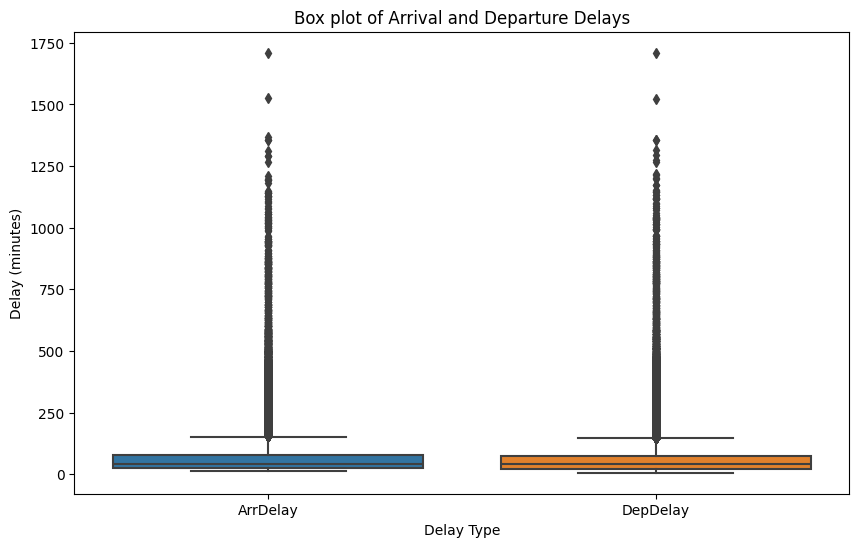

In [212]:
# Box plot for Arrival and Departure Delays
plt.figure(figsize=(10, 6))
sns.boxplot(data=pdf[['ArrDelay', 'DepDelay']])
plt.title('Box plot of Arrival and Departure Delays')
plt.xlabel('Delay Type')
plt.ylabel('Delay (minutes)')
plt.show()

Route with highest average delay: EGE-MIA with 320.44 minutes
Route with lowest average delay: LAX-JAX with 15.00 minutes


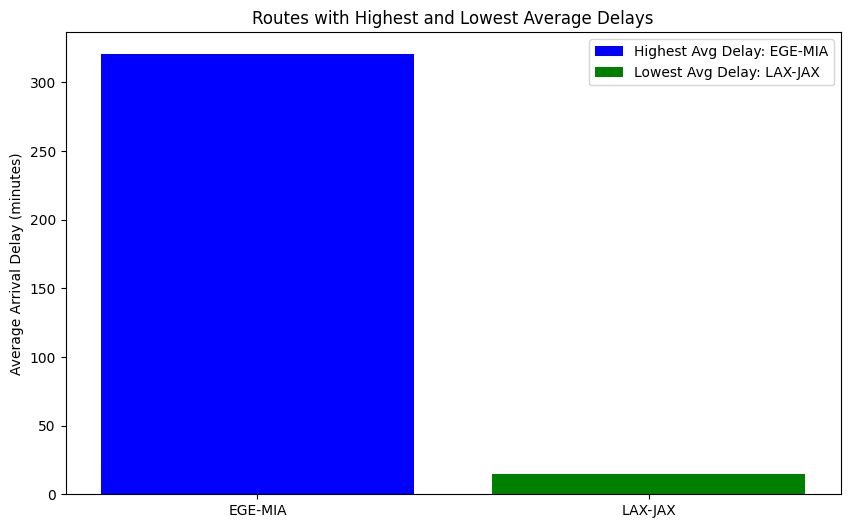

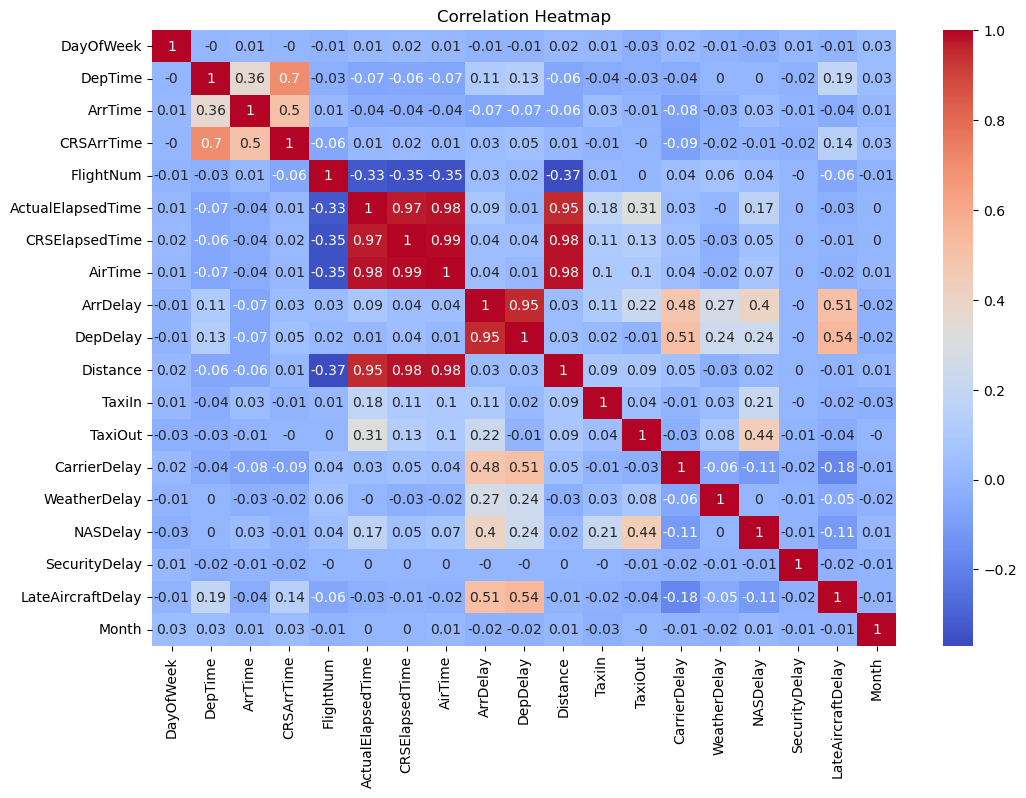

In [12]:
# Filter out non-numeric columns for correlation heatmap
numeric_cols = pdf.select_dtypes(include=[np.number]).columns
numeric_cols=numeric_cols.drop("Cancelled")
numeric_cols=numeric_cols.drop("Diverted")
numeric_cols=numeric_cols.drop("Year")

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pdf[numeric_cols].corr().round(2), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

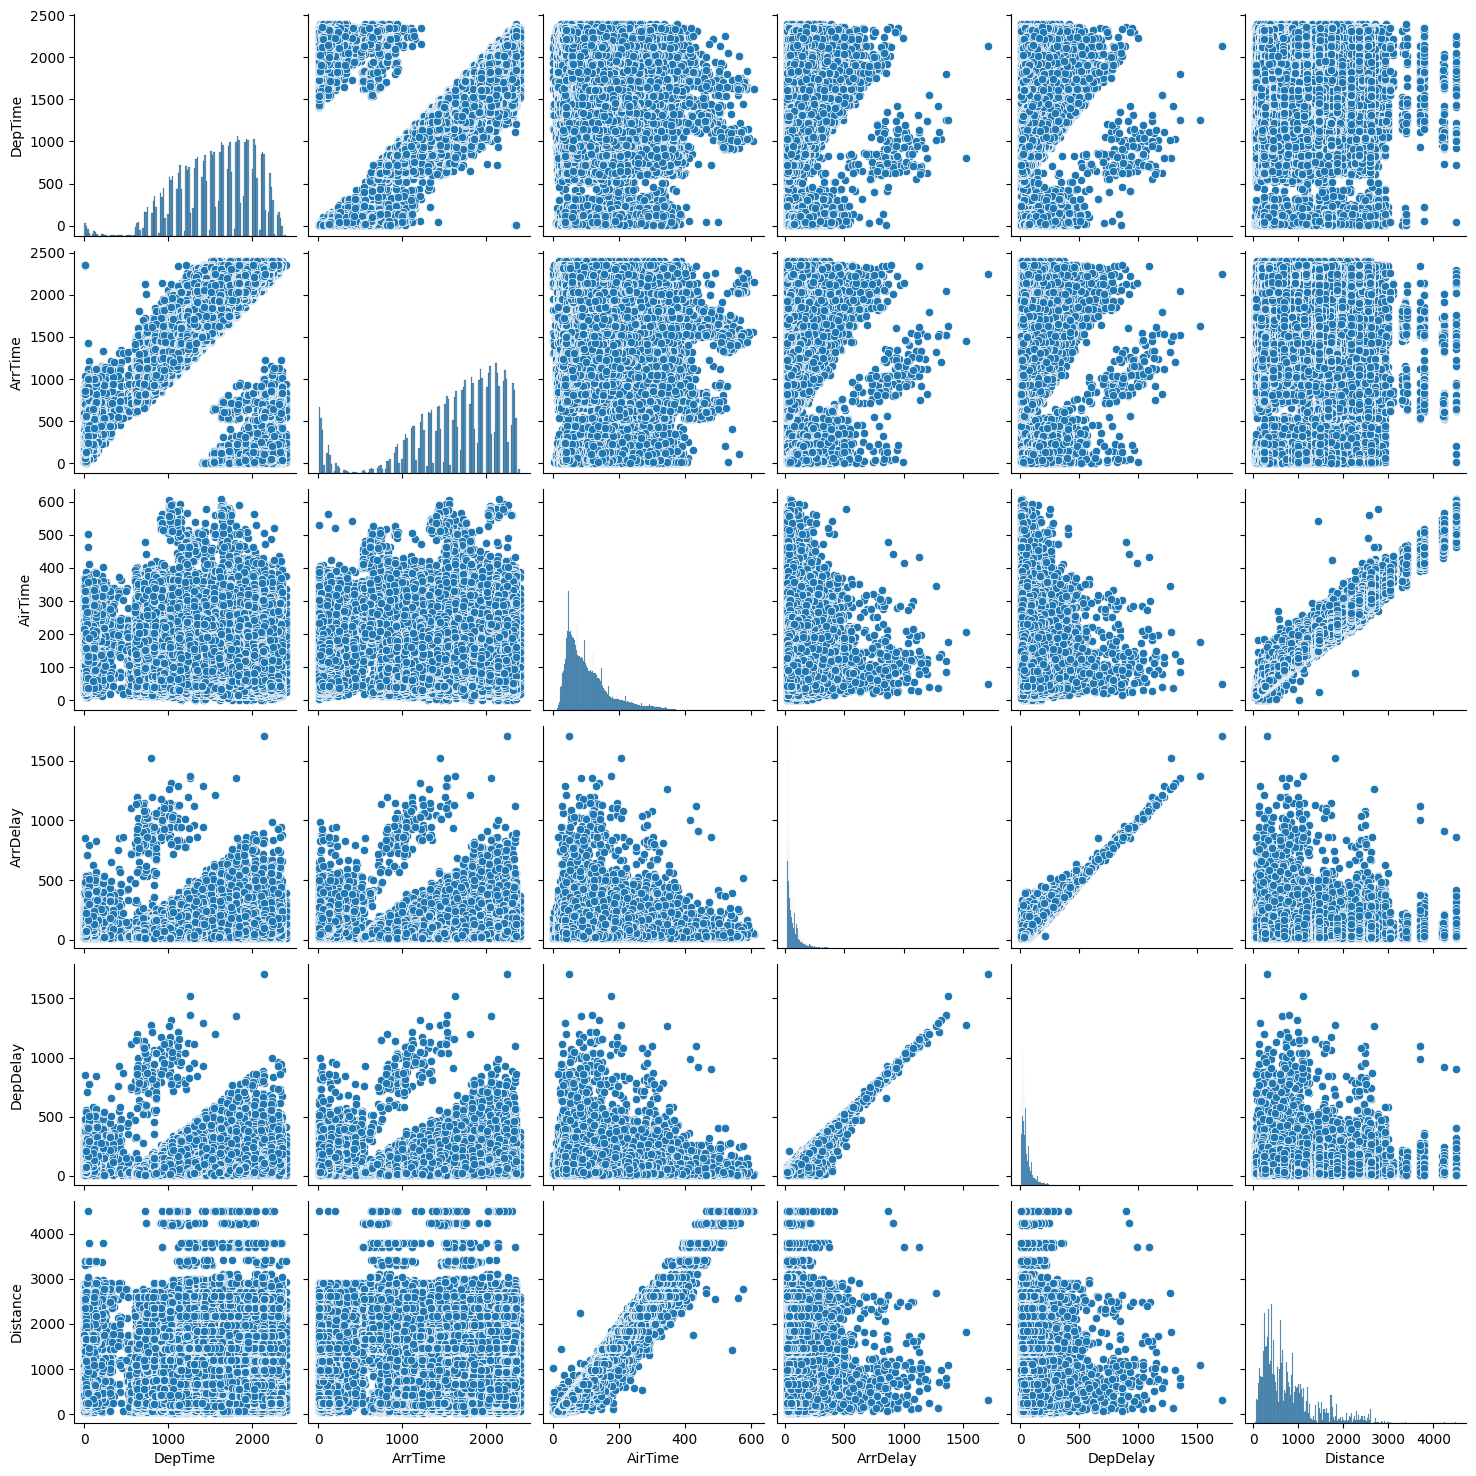

In [216]:
# Pair plot for numerical features
sns.pairplot(pdf[['DepTime', 'ArrTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance']])
plt.show()

In [217]:
# Creating a new dataframe by combining different types of delays
data = [pdf['CarrierDelay'], pdf['WeatherDelay'], pdf['NASDelay'], pdf['SecurityDelay'], pdf['LateAircraftDelay']]
headers = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
df_delays = pd.concat(data, axis=1, keys=headers)
print(df_delays.head())

   CarrierDelay  WeatherDelay  NASDelay  SecurityDelay  LateAircraftDelay
0             2             0         0              0                 32
1            10             0         0              0                 47
2             8             0         0              0                 72
3             3             0         0              0                 12
4             0             0         0              0                 16


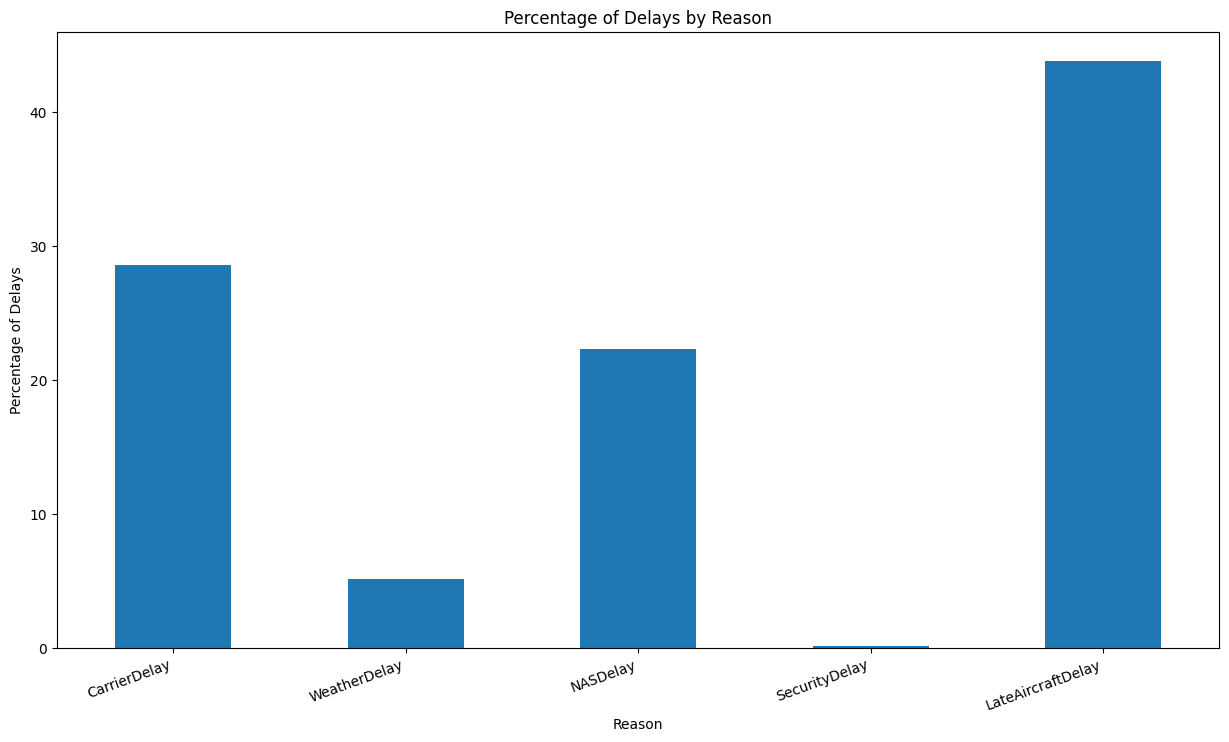

In [218]:
# Plot delays by reasons
delay_reasons = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
delays_by_reason = pdf[delay_reasons].sum()
delays_by_reason_percentage = (delays_by_reason / total_delays) * 100

plt.figure(figsize=(15, 8))
delays_by_reason_percentage.plot(kind='bar')
plt.title('Percentage of Delays by Reason')
plt.xlabel('Reason')
plt.ylabel('Percentage of Delays')
plt.xticks(rotation=20, ha='right')
plt.show()

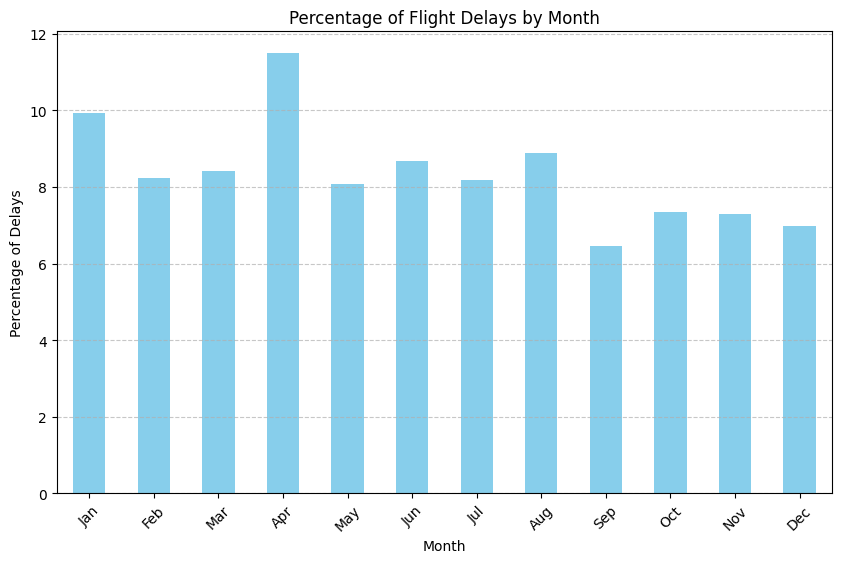

In [219]:
data = pd.read_csv('Flight_delay.csv')
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # Converts 'Date' to datetime, handling errors
data['Month'] = data['Date'].dt.month  # Extracts month from 'Date'

# Calculate monthly delay percentages
monthly_delays = data.groupby('Month')['ArrDelay'].sum()
percentage_delays = (monthly_delays / monthly_delays.sum()) * 100

# Plotting
plt.figure(figsize=(10, 6))
percentage_delays.plot(kind='bar', color='skyblue')
plt.title('Percentage of Flight Delays by Month')
plt.xlabel('Month')
plt.ylabel('Percentage of Delays')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Top 10 Routes with Most Flight Delays

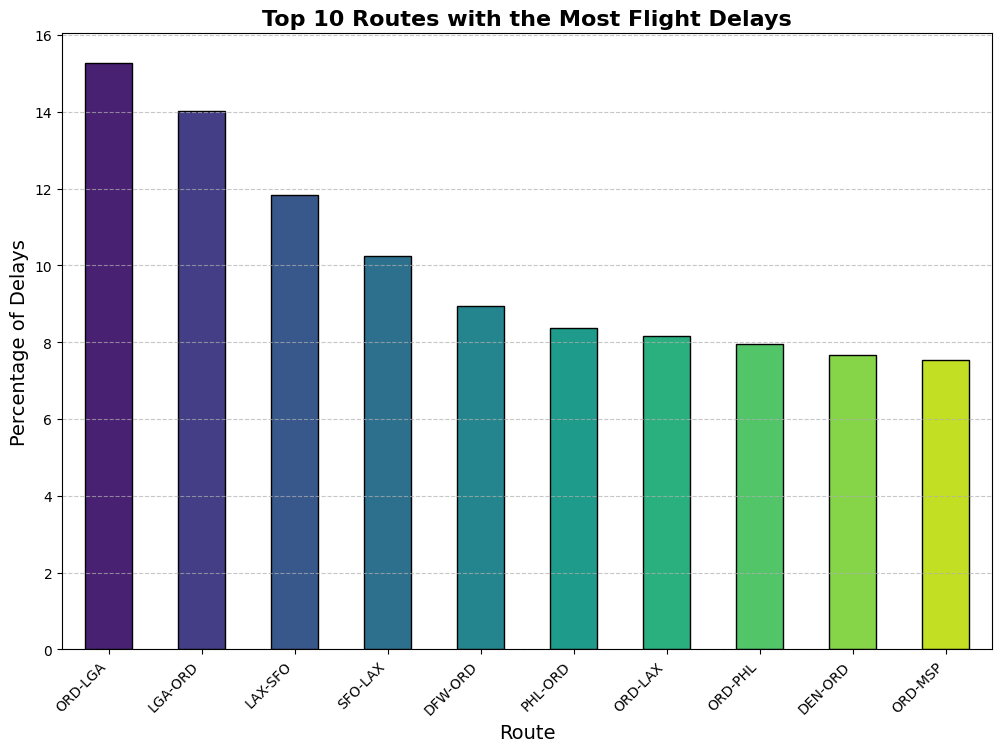

In [240]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your DataFrame
data['Route'] = data['Origin'] + '-' + data['Dest']
route_delays = data.groupby('Route')['ArrDelay'].sum()
top_routes = route_delays.nlargest(10)  # Top 10 routes with the most delays
percentage_top_routes = (top_routes / top_routes.sum()) * 100

# Plotting top route delays with enhanced visuals
plt.figure(figsize=(12, 8))
palette = sns.color_palette("viridis", len(top_routes))  # Using a viridis color palette
percentage_top_routes.plot(kind='bar', color=palette, edgecolor='black')

# Adding titles and labels
plt.title('Top 10 Routes with the Most Flight Delays', fontsize=16, weight='bold')
plt.xlabel('Route', fontsize=14)
plt.ylabel('Percentage of Delays', fontsize=14)

# Adding grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Displaying the plot
plt.show()


# MODEL TRAINING

# Importing Libraries

In [97]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import warnings

warnings.filterwarnings('ignore')


# Evaluation and Display Results Function

Model: Random Forest
  RMSE: 20.1822
  R2: 0.8759
  MAE: 11.1781
  AUC ROC: 0.5000
  Precision: 0.9731
  Recall: 1.0000
  F1 Score: 0.9864


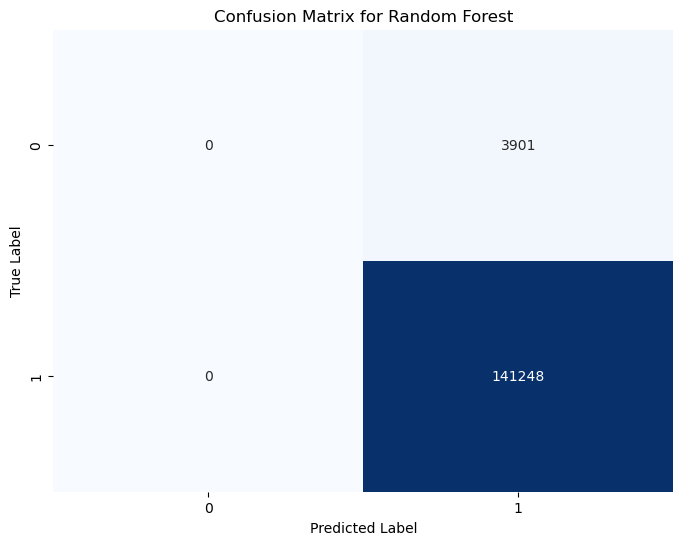

--------------------------------------------------
Model: Gradient-Boosted Trees
  RMSE: 15.3791
  R2: 0.9280
  MAE: 4.5545
  AUC ROC: 0.5003
  Precision: 0.9731
  Recall: 1.0000
  F1 Score: 0.9864


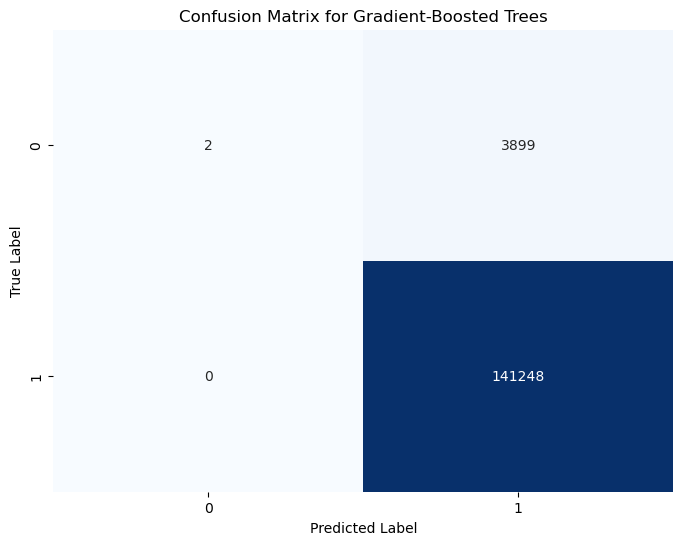

--------------------------------------------------
Model: Linear Regression
  RMSE: 16.3178
  R2: 0.9189
  MAE: 10.3746
  AUC ROC: 0.5897
  Precision: 0.9780
  Recall: 0.9600
  F1 Score: 0.9689


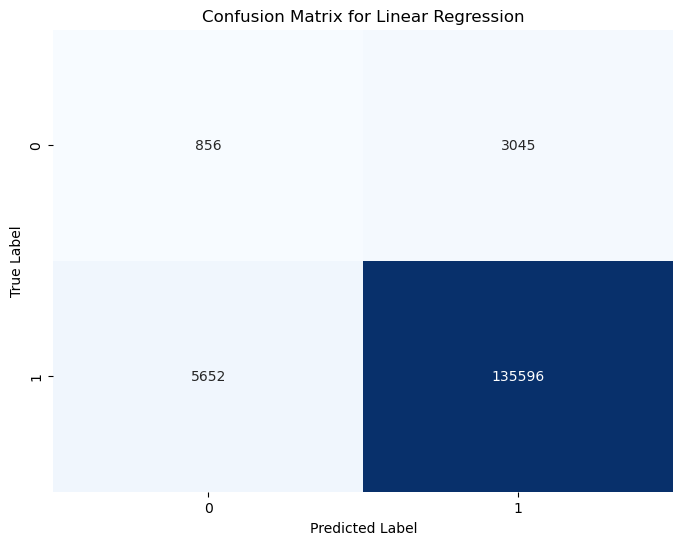

--------------------------------------------------


In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

# Define a function to calculate additional metrics
def calculate_additional_metrics(y_true, y_pred, threshold=15):
    y_true_bin = (y_true > threshold).astype(int)
    y_pred_bin = (y_pred > threshold).astype(int)
    
    auc_roc = roc_auc_score(y_true_bin, y_pred_bin)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_bin, y_pred_bin, average='binary')
    
    return auc_roc, precision, recall, f1

# Define a function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Define a function to evaluate and display all metrics, including the confusion matrix
def evaluate_and_display(model, predictions, model_name):
    evaluator_rmse = RegressionEvaluator(labelCol='ArrDelay', predictionCol='prediction', metricName='rmse')
    evaluator_r2 = RegressionEvaluator(labelCol='ArrDelay', predictionCol='prediction', metricName='r2')
    evaluator_mae = RegressionEvaluator(labelCol='ArrDelay', predictionCol='prediction', metricName='mae')
    
    rmse = evaluator_rmse.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    
    pd_predictions = predictions.select(['prediction', 'ArrDelay']).toPandas()
    auc_roc, precision, recall, f1 = calculate_additional_metrics(pd_predictions['ArrDelay'], pd_predictions['prediction'])
    
    print(f"Model: {model_name}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  AUC ROC: {auc_roc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    
    # Calculate and plot the confusion matrix
    y_true_bin = (pd_predictions['ArrDelay'] > 15).astype(int)
    y_pred_bin = pd_predictions['prediction'].apply(lambda x: 1 if x > 15 else 0)
    plot_confusion_matrix(y_true_bin, y_pred_bin, model_name)
    
    print("--------------------------------------------------")

#  rf_model, gbt_model, lr_model are defined and rf_predictions, gbt_predictions, lr_predictions are available
evaluate_and_display(rf_model, rf_predictions, "Random Forest")
evaluate_and_display(gbt_model, gbt_predictions, "Gradient-Boosted Trees")
evaluate_and_display(lr_model, lr_predictions, "Linear Regression")


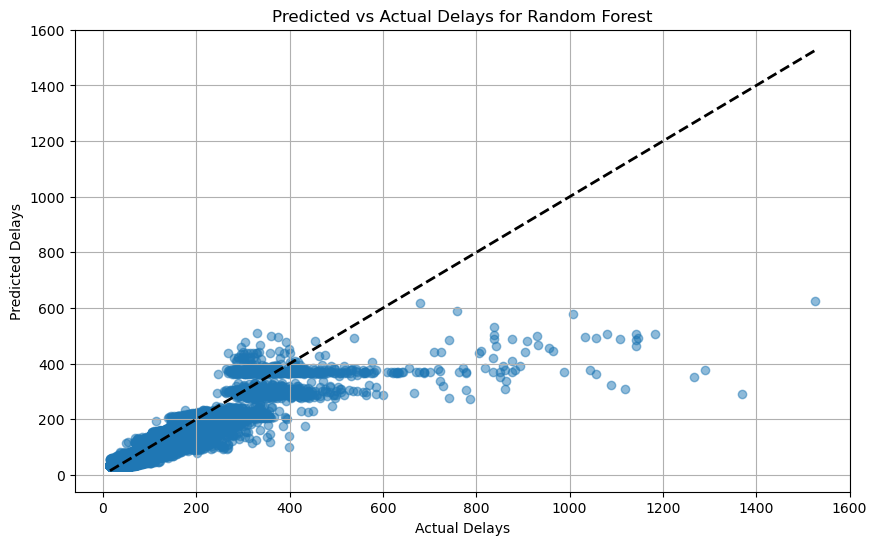

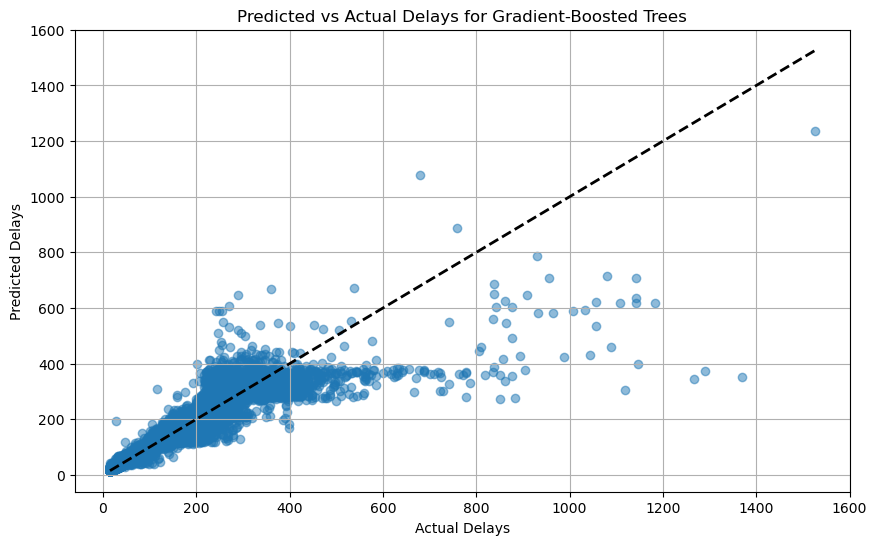

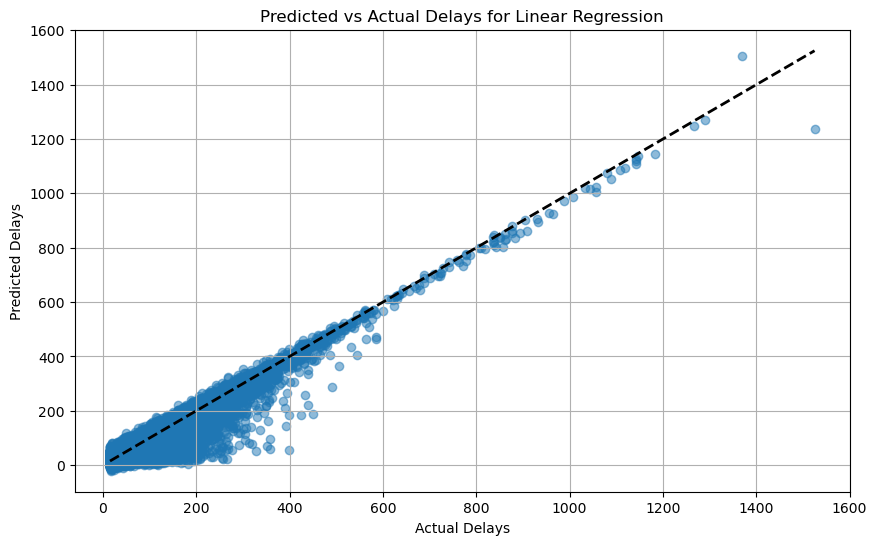

In [118]:
import matplotlib.pyplot as plt

def plot_predictions(predictions, model_name):
    # Convert to pandas DataFrame
    pd_predictions = predictions.select("prediction", "ArrDelay").toPandas()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(pd_predictions['ArrDelay'], pd_predictions['prediction'], alpha=0.5)
    plt.title(f'Predicted vs Actual Delays for {model_name}')
    plt.xlabel('Actual Delays')
    plt.ylabel('Predicted Delays')
    plt.plot([pd_predictions['ArrDelay'].min(), pd_predictions['ArrDelay'].max()],
             [pd_predictions['ArrDelay'].min(), pd_predictions['ArrDelay'].max()],
             'k--', lw=2)  # Diagonal line where predicted = actual
    plt.grid(True)
    plt.show()

#  function to plot for each model
plot_predictions(rf_predictions, "Random Forest")
plot_predictions(gbt_predictions, "Gradient-Boosted Trees")
plot_predictions(lr_predictions, "Linear Regression")


In [84]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Start Spark session with increased memory and detailed logging
spark = SparkSession.builder \
    .appName("FlightDelayPrediction") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

# Set log level to INFO to monitor the job execution
spark.sparkContext.setLogLevel("INFO")

# Load the dataset
df = spark.read.csv("Flight_delay.csv", header=True, inferSchema=True)

df = df.repartition(200)  

# Optional: Test with a smaller sample of the data
sample_df = df.sample(fraction=0.1, withReplacement=False)

# Define feature columns
feature_columns = ['DepTime', 'ArrTime', 'AirTime', 'DepDelay', 'Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
feature_vector_df = assembler.transform(sample_df)  # Change sample_df to df for full data processing

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scaler_model = scaler.fit(feature_vector_df)
scaled_df = scaler_model.transform(feature_vector_df)

# Collecting data for deep learning
features = np.array(scaled_df.select("scaledFeatures").collect())
target = np.array(sample_df.select("ArrDelay").collect()).flatten()

# Reshape features for model input
def reshape_features_for_cnn(features):
    return features.reshape(features.shape[0], features.shape[2], 1)  # Adjust dimensions for CNN

def reshape_features_for_lstm(features):
    return features.reshape(features.shape[0], 1, features.shape[2])  # Adjust dimensions for LSTM

# Define CNN model
def build_cnn_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=2, activation='relu', input_shape=input_shape),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

#  Function to print metrics
def print_evaluation_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"Model: {model_name}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")

# Train and evaluate CNN model
features_cnn = reshape_features_for_cnn(features)
cnn_model = build_cnn_model((features_cnn.shape[1], features_cnn.shape[2]))
cnn_model.fit(features_cnn, target, epochs=10, batch_size=32, verbose=1)
predictions_cnn = cnn_model.predict(features_cnn).flatten()
print_evaluation_metrics(target, predictions_cnn, "CNN")

# Train and evaluate LSTM model
features_lstm = reshape_features_for_lstm(features)
lstm_model = build_lstm_model((1, features_lstm.shape[2]))
lstm_model.fit(features_lstm, target, epochs=10, batch_size=32, verbose=1)
predictions_lstm = lstm_model.predict(features_lstm).flatten()
print_evaluation_metrics(target, predictions_lstm, "LSTM")

# Stop the Spark session
spark.stop()


Epoch 1/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 3937.9250
Epoch 2/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 3244.5945
Epoch 3/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3368.0525
Epoch 4/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3215.3801
Epoch 5/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3268.6484
Epoch 6/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 3154.0857
Epoch 7/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3359.0266
Epoch 8/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 3232.2947
Epoch 9/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3244.7542
Epoch 10/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 3317.2620
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Model: CNN
  RMSE: 57.6590
  R2: -0.0049
  MAE: 37.1990
Epoch 1/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 5587.7490
Epoch 2/10
1509/1509 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 3652.5139
Epoch 3/10
1509/1509 ━━━━━━━━━━━━━━━

In [85]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM, Dropout
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, roc_auc_score, precision_recall_fscore_support

# Start Spark session with increased memory and detailed logging
spark = SparkSession.builder \
    .appName("FlightDelayPrediction") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

# Set log level to INFO
spark.sparkContext.setLogLevel("INFO")

# Load the dataset
df = spark.read.csv("Flight_delay.csv", header=True, inferSchema=True)


# Define feature columns
feature_columns = ['DepTime', 'ArrTime', 'AirTime', 'DepDelay', 'Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
feature_vector_df = assembler.transform(df)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scaler_model = scaler.fit(feature_vector_df)
scaled_df = scaler_model.transform(feature_vector_df)

# Split the data into training and testing sets
train_df, test_df = scaled_df.randomSplit([0.7, 0.3], seed=42)

# Collect data for deep learning
features = np.array(scaled_df.select("scaledFeatures").collect())
target = np.array(df.select("ArrDelay").collect()).flatten()

# Binary classification target for ROC and Precision-Recall
target_binary = (target > 15).astype(int)  # Assuming delay > 15 minutes is significant

# Reshape features for model input
def reshape_features_for_cnn(features):
    return features.reshape(features.shape[0], features.shape[2], 1)

def reshape_features_for_lstm(features):
    return features.reshape(features.shape[0], 1, features.shape[2])

#   CNN Model
def build_improved_cnn_model(input_shape):
    model = Sequential([
        Conv1D(128, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
        Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

#  LSTM Model
def build_improved_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=input_shape),
        LSTM(100, activation='relu'),
        Dropout(0.5),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

#  function to print metrics
def print_evaluation_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    auc_roc = roc_auc_score((y_true > 15).astype(int), (y_pred > 15).astype(int))
    precision, recall, f1, _ = precision_recall_fscore_support((y_true > 15).astype(int), (y_pred > 15).astype(int), average='binary')
    print(f"Model: {model_name}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  AUC ROC: {auc_roc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")

# Train and evaluate models
features_cnn = reshape_features_for_cnn(features)
cnn_model = build_improved_cnn_model((features_cnn.shape[1], features_cnn.shape[2]))
cnn_model.fit(features_cnn, target, epochs=10, batch_size=32, verbose=1)
predictions_cnn = cnn_model.predict(features_cnn).flatten()
print_evaluation_metrics(target, predictions_cnn, "CNN")

features_lstm = reshape_features_for_lstm(features)
lstm_model = build_improved_lstm_model((1, features_lstm.shape[2]))
lstm_model.fit(features_lstm, target, epochs=10, batch_size=32, verbose=1)
predictions_lstm = lstm_model.predict(features_lstm).flatten()
print_evaluation_metrics(target, predictions_lstm, "LSTM")

# Stop the Spark session
spark.stop()


Epoch 1/10
15143/15143 ━━━━━━━━━━━━━━━━━━━━ 128s 8ms/step - loss: 253.4828
Epoch 2/10
15143/15143 ━━━━━━━━━━━━━━━━━━━━ 125s 8ms/step - loss: 125.2933
Epoch 3/10
15143/15143 ━━━━━━━━━━━━━━━━━━━━ 126s 8ms/step - loss: 111.5026
Epoch 4/10
15143/15143 ━━━━━━━━━━━━━━━━━━━━ 123s 8ms/step - loss: 100.0618
Epoch 5/10
15143/15143 ━━━━━━━━━━━━━━━━━━━━ 120s 8ms/step - loss: 97.2323
Epoch 6/10
15143/15143 ━━━━━━━━━━━━━━━━━━━━ 117s 8ms/step - loss: 91.4273
Epoch 7/10
15143/15143 ━━━━━━━━━━━━━━━━━━━━ 116s 8ms/step - loss: 89.6528
Epoch 8/10
15143/15143 ━━━━━━━━━━━━━━━━━━━━ 117s 8ms/step - loss: 86.4492
Epoch 9/10
15143/15143 ━━━━━━━━━━━━━━━━━━━━ 120s 8ms/step - loss: 86.4308
Epoch 10/10
15143/15143 ━━━━━━━━━━━━━━━━━━━━ 124s 8ms/step - loss: 86.0944
15143/15143 ━━━━━━━━━━━━━━━━━━━━ 55s 4ms/step
Model: CNN
  RMSE: 3.7825
  R2: 0.9956
  MAE: 1.8341
  AUC ROC: 0.5000
  Precision: 0.9731
  Recall: 1.0000
  F1 Score: 0.9864
Epoch 1/10
15143/15143 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - loss: 358.6675
Epoch 2/

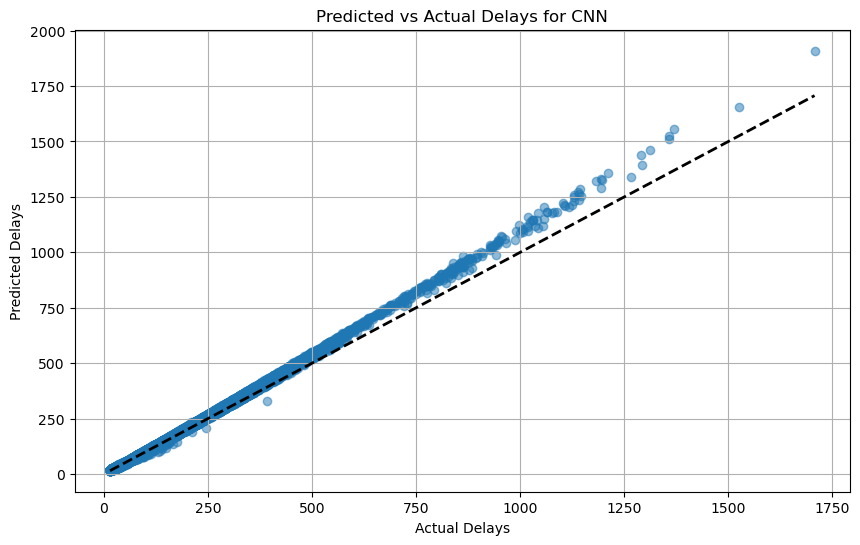

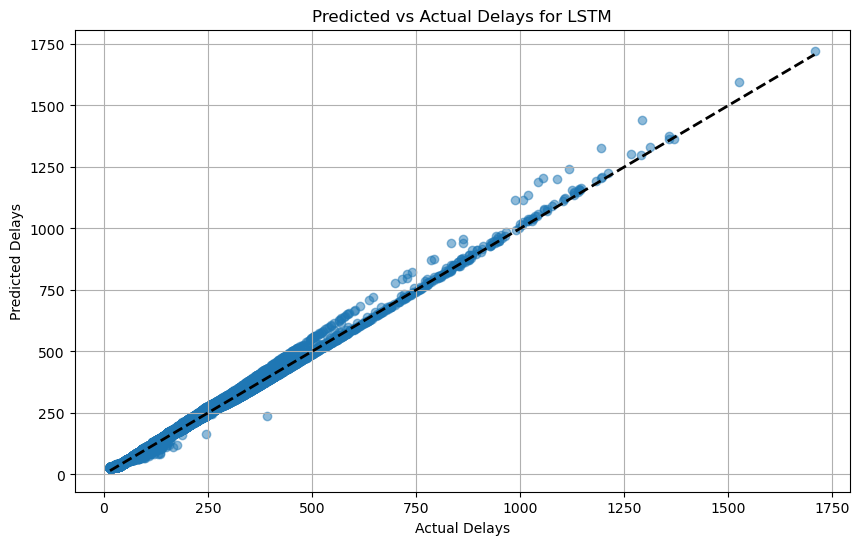

In [119]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dl_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.title(f'Predicted vs Actual Delays for {model_name}')
    plt.xlabel('Actual Delays')
    plt.ylabel('Predicted Delays')
    plt.plot([np.min(y_true), np.max(y_true)],
             [np.min(y_true), np.max(y_true)],
             'k--', lw=2)  # Diagonal line where predicted = actual
    plt.grid(True)
    plt.show()


plot_dl_predictions(target, predictions_cnn, "CNN")
plot_dl_predictions(target, predictions_lstm, "LSTM")


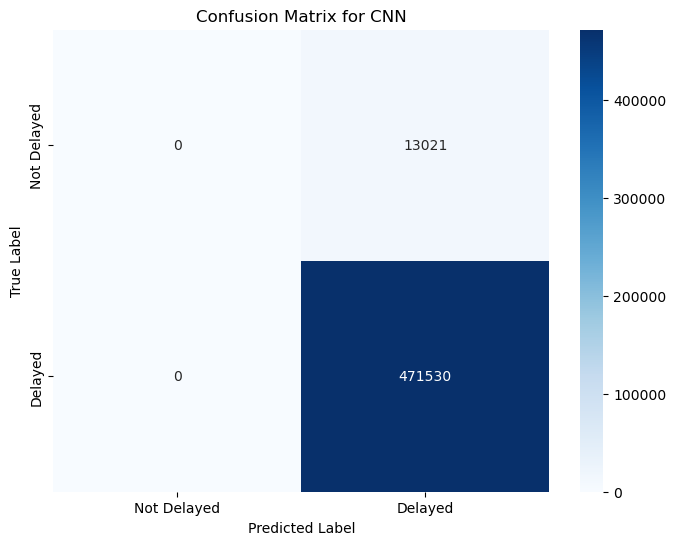

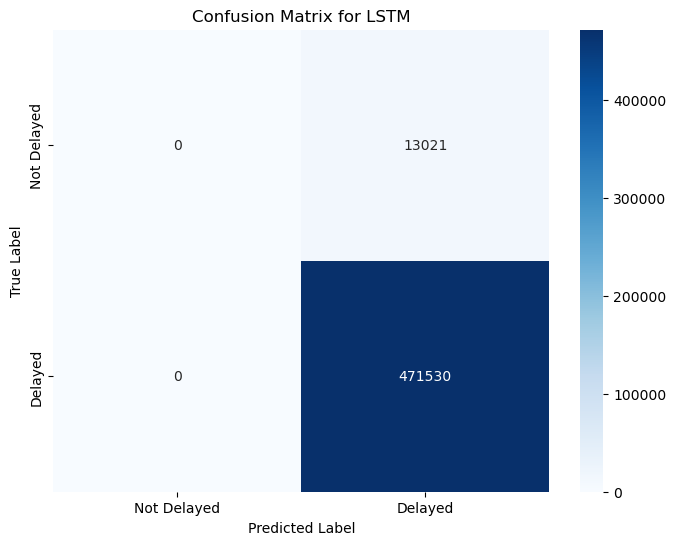

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to convert continuous predictions to binary class labels
def get_binary_predictions(predictions, threshold=15):
    return (predictions > threshold).astype(int)

# Function to calculate and plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


binary_predictions_cnn = get_binary_predictions(predictions_cnn, threshold=15)
binary_predictions_lstm = get_binary_predictions(predictions_lstm, threshold=15)

# Ploting confusion matrix for CNN
plot_confusion_matrix(target_binary, binary_predictions_cnn, classes=["Not Delayed", "Delayed"], model_name="CNN")

# Plot confusion matrix for LSTM
plot_confusion_matrix(target_binary, binary_predictions_lstm, classes=["Not Delayed", "Delayed"], model_name="LSTM")


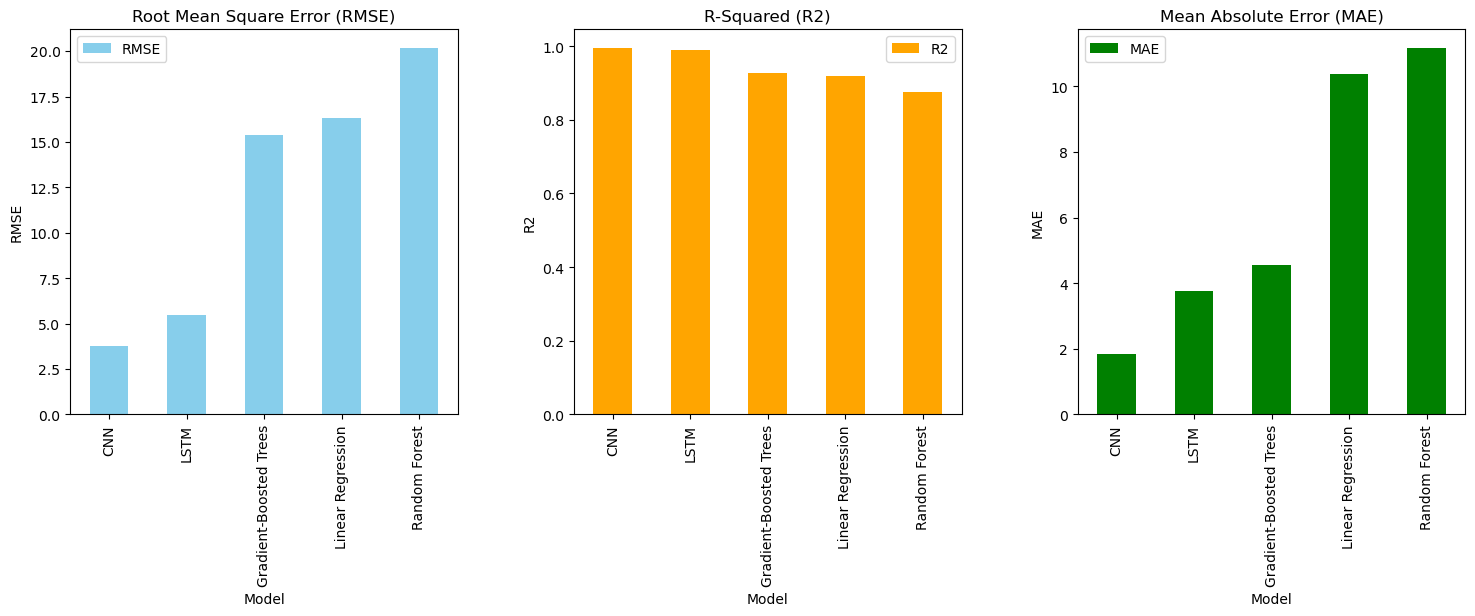

In [88]:
import matplotlib.pyplot as plt
import pandas as pd

# Data preparation
data = {
    'Model': ['Random Forest', 'Gradient-Boosted Trees', 'Linear Regression', 'CNN', 'LSTM'],
    'RMSE': [20.1822, 15.3791, 16.3178, 3.7825, 5.4627],
    'R2': [0.8759, 0.9280, 0.9189, 0.9956, 0.9908],
    'MAE': [11.1781, 4.5545, 10.3746, 1.8341, 3.7580]
}

df = pd.DataFrame(data)

# matplotlib figure for RMSE, R², and MAE
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# RMSE
df.sort_values('RMSE').plot(x='Model', y='RMSE', kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Root Mean Square Error (RMSE)')
axes[0].set_ylabel('RMSE')

# R2
df.sort_values('R2', ascending=False).plot(x='Model', y='R2', kind='bar', ax=axes[1], color='orange')
axes[1].set_title('R-Squared (R2)')
axes[1].set_ylabel('R2')

# MAE
df.sort_values('MAE').plot(x='Model', y='MAE', kind='bar', ax=axes[2], color='green')
axes[2].set_title('Mean Absolute Error (MAE)')
axes[2].set_ylabel('MAE')

plt.show()


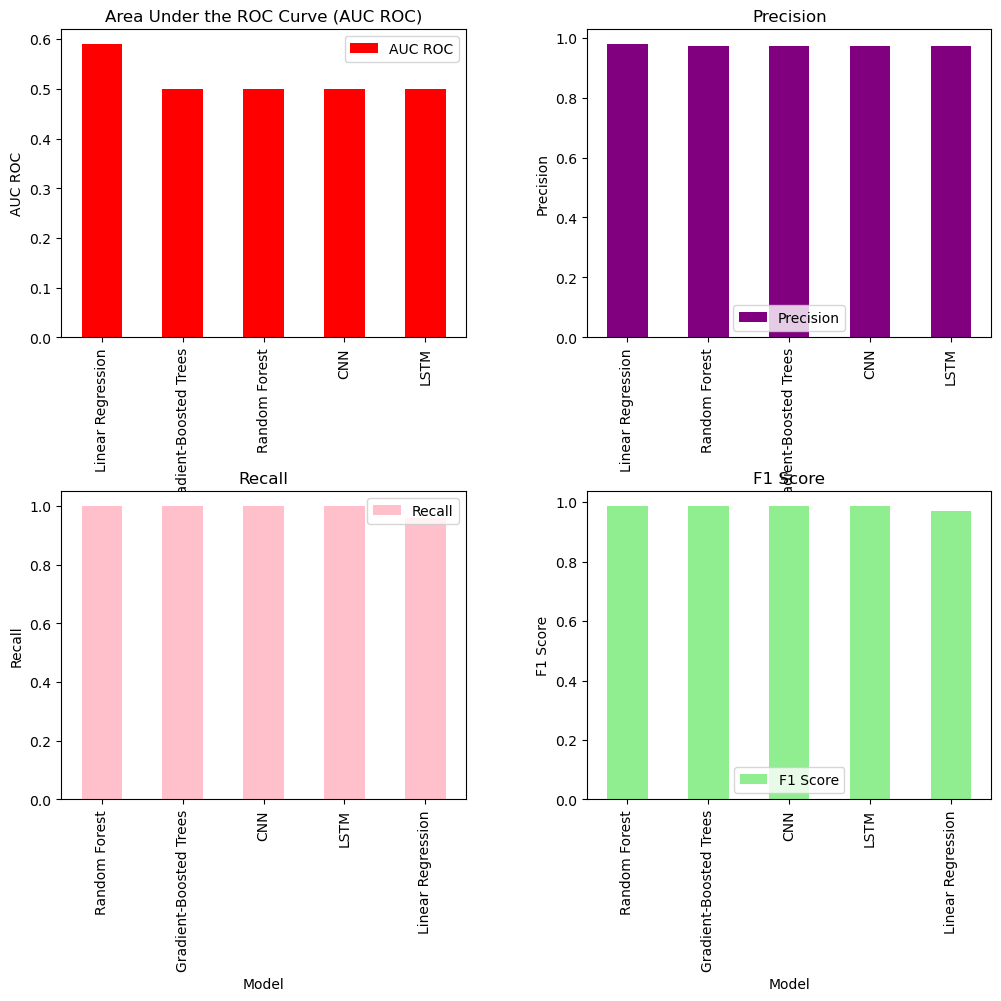

In [90]:
# Data preparation for AUC ROC, Precision, Recall, F1 Score
data = {
    'Model': ['Random Forest', 'Gradient-Boosted Trees', 'Linear Regression', 'CNN', 'LSTM'],
    'AUC ROC': [0.5000, 0.5003, 0.5897, 0.5000, 0.5000],
    'Precision': [0.9731, 0.9731, 0.9780, 0.9731, 0.9731],
    'Recall': [1.0000, 1.0000, 0.9600, 1.0000, 1.0000],
    'F1 Score': [0.9864, 0.9864, 0.9689, 0.9864, 0.9864]
}

df = pd.DataFrame(data)

# matplotlib figure for AUC ROC, Precision, Recall, F1 Score
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# AUC ROC
df.sort_values('AUC ROC', ascending=False).plot(x='Model', y='AUC ROC', kind='bar', ax=axes[0, 0], color='red')
axes[0, 0].set_title('Area Under the ROC Curve (AUC ROC)')
axes[0, 0].set_ylabel('AUC ROC')

# Precision
df.sort_values('Precision', ascending=False).plot(x='Model', y='Precision', kind='bar', ax=axes[0, 1], color='purple')
axes[0, 1].set_title('Precision')
axes[0, 1].set_ylabel('Precision')

# Recall
df.sort_values('Recall', ascending=False).plot(x='Model', y='Recall', kind='bar', ax=axes[1, 0], color='pink')
axes[1, 0].set_title('Recall')
axes[1, 0].set_ylabel('Recall')

# F1 Score
df.sort_values('F1 Score', ascending=False).plot(x='Model', y='F1 Score', kind='bar', ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_title('F1 Score')
axes[1, 1].set_ylabel('F1 Score')

plt.show()


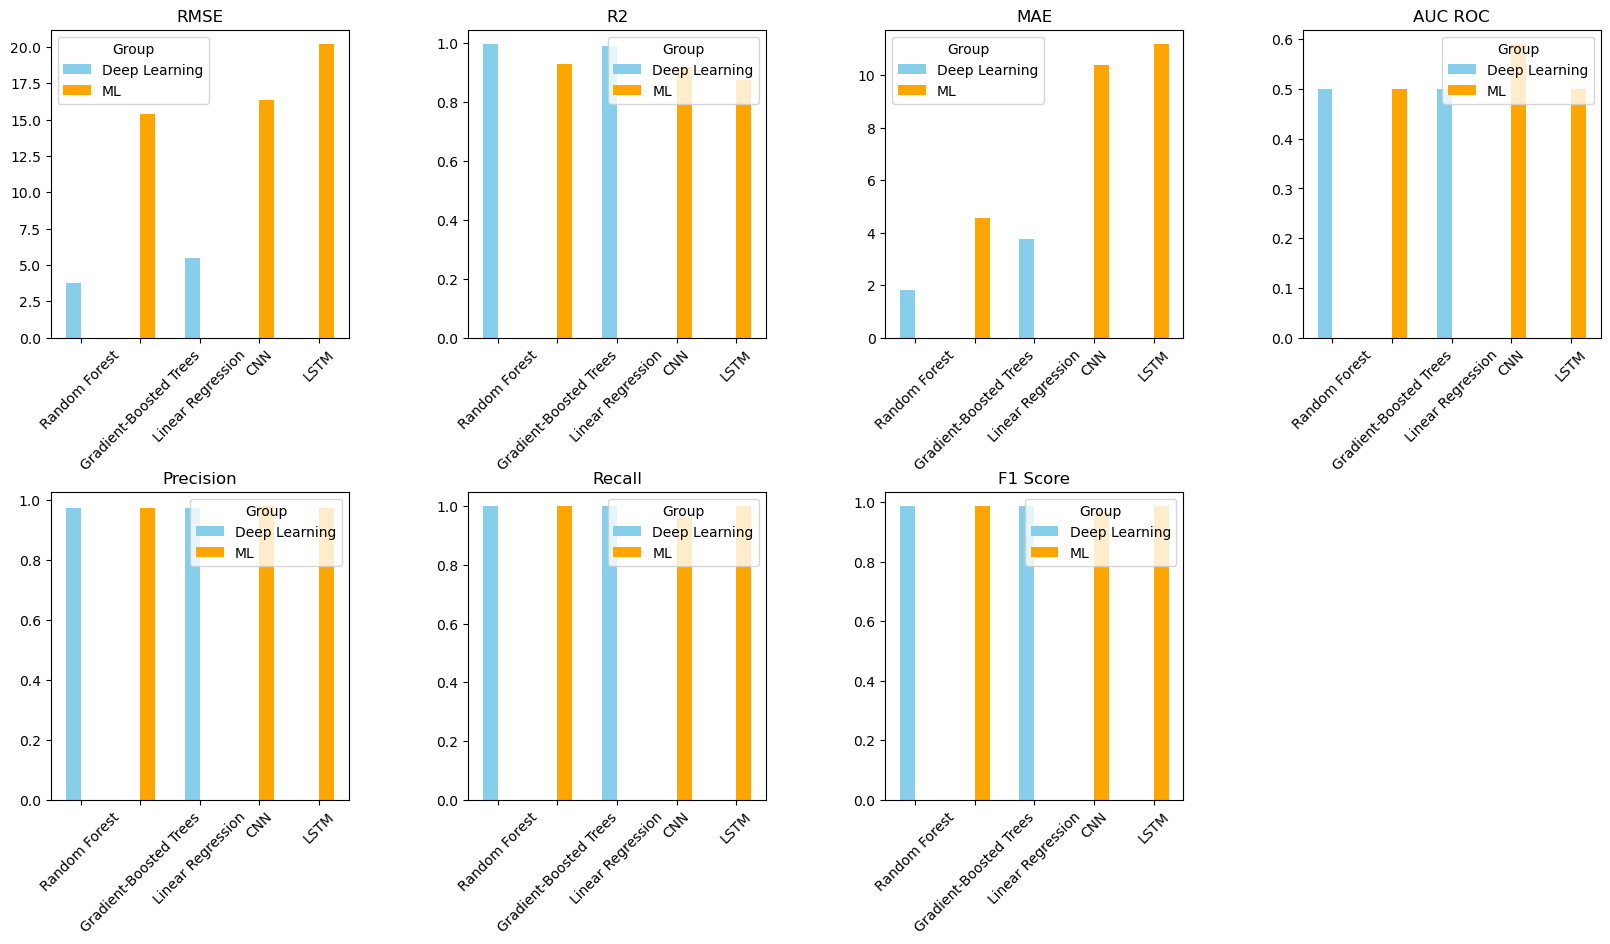

In [91]:
import matplotlib.pyplot as plt
import pandas as pd

# Data preparation
data = {
    'Model': ['Random Forest', 'Gradient-Boosted Trees', 'Linear Regression', 'CNN', 'LSTM'],
    'RMSE': [20.1822, 15.3791, 16.3178, 3.7825, 5.4627],
    'R2': [0.8759, 0.9280, 0.9189, 0.9956, 0.9908],
    'MAE': [11.1781, 4.5545, 10.3746, 1.8341, 3.7580],
    'AUC ROC': [0.5000, 0.5003, 0.5897, 0.5000, 0.5000],
    'Precision': [0.9731, 0.9731, 0.9780, 0.9731, 0.9731],
    'Recall': [1.0000, 1.0000, 0.9600, 1.0000, 1.0000],
    'F1 Score': [0.9864, 0.9864, 0.9689, 0.9864, 0.9864]
}

df = pd.DataFrame(data)

#  group labels for plotting
group_labels = ['ML', 'ML', 'ML', 'Deep Learning', 'Deep Learning']
df['Group'] = group_labels

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

#  function to create grouped bar plot
def grouped_barplot(ax, metric):
    df.pivot(index='Model', columns='Group', values=metric).plot(kind='bar', ax=ax, color=['skyblue', 'orange'])
    ax.set_title(metric)
    ax.set_xlabel('')
    ax.set_xticklabels(df['Model'], rotation=45)
    ax.legend(title='Group')

# RMSE
grouped_barplot(axes[0, 0], 'RMSE')

# R2
grouped_barplot(axes[0, 1], 'R2')

# MAE
grouped_barplot(axes[0, 2], 'MAE')

# AUC ROC
grouped_barplot(axes[0, 3], 'AUC ROC')

# Precision
grouped_barplot(axes[1, 0], 'Precision')

# Recall
grouped_barplot(axes[1, 1], 'Recall')

# F1 Score
grouped_barplot(axes[1, 2], 'F1 Score')

# Hide unused subplot for a cleaner look
fig.delaxes(axes[1, 3])

plt.show()


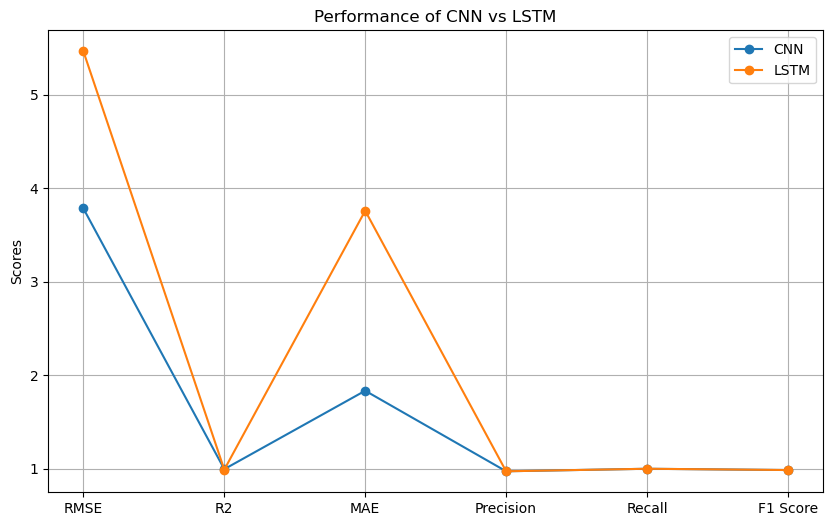

In [122]:
# Data for visualization
models = ['CNN', 'LSTM']
metrics = ['RMSE', 'R2', 'MAE', 'Precision', 'Recall', 'F1 Score']
values_cnn = [3.7825, 0.9956, 1.8341, 0.9731, 1.0000, 0.9864]
values_lstm = [5.4627, 0.9908, 3.7580, 0.9731, 1.0000, 0.9864]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(metrics, values_cnn, label='CNN', marker='o')
ax.plot(metrics, values_lstm, label='LSTM', marker='o')
ax.set_ylabel('Scores')
ax.set_title('Performance of CNN vs LSTM')
plt.legend()
plt.grid(True)
plt.show()
